In [1]:
import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [2]:
df = pd.read_csv("orders.csv")
df = df.loc[df['payment_cost']!=0]
#df = df.loc[df['tariff_internal_name']=='econom']
df = df.dropna()

In [3]:
#Converting to date-time
df = df[['created_at_utc','payment_cost']]
df['created_at_utc'] = pd.to_datetime(df.created_at_utc,unit='s')
df.sort_values(by=['created_at_utc'], inplace=True)
df = df.loc[(df['created_at_utc'].dt.year != 2017) & (df['created_at_utc'].dt.year != 2018)]
df.set_index('created_at_utc', inplace=True)

In [4]:
# Creating a copy of the initial datagrame to make various transformations
data = df.copy()
data.columns = ["y"]

In [5]:
# plt.figure(figsize=(12, 6))
# plt.plot(data.y)
# plt.title("asxasf)")
# plt.grid(True)
# plt.show()

In [6]:
# Importing everything from above

from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Moving average.

In [7]:
def plotMovingAverage(series, 
                      window, 
                      plot_graph=False, 
                      plot_intervals=False, 
                      scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window,min_periods=1).mean()

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    if plot_graph:        
        plt.figure(figsize=(15, 5))
        plt.title("Moving average\n window size = {}".format(window))
        plt.plot(rolling_mean, "g", label="Rolling mean trend")
        plt.plot(series[window:], label="Actual values",alpha=0.5)
        plt.legend(loc="upper left")
        plt.grid(True)
        plt.show()
    
    return rolling_mean 

# Start Here

Automate the process w.r.t window, additional features and finally, another smoothing

Tune ensembles.

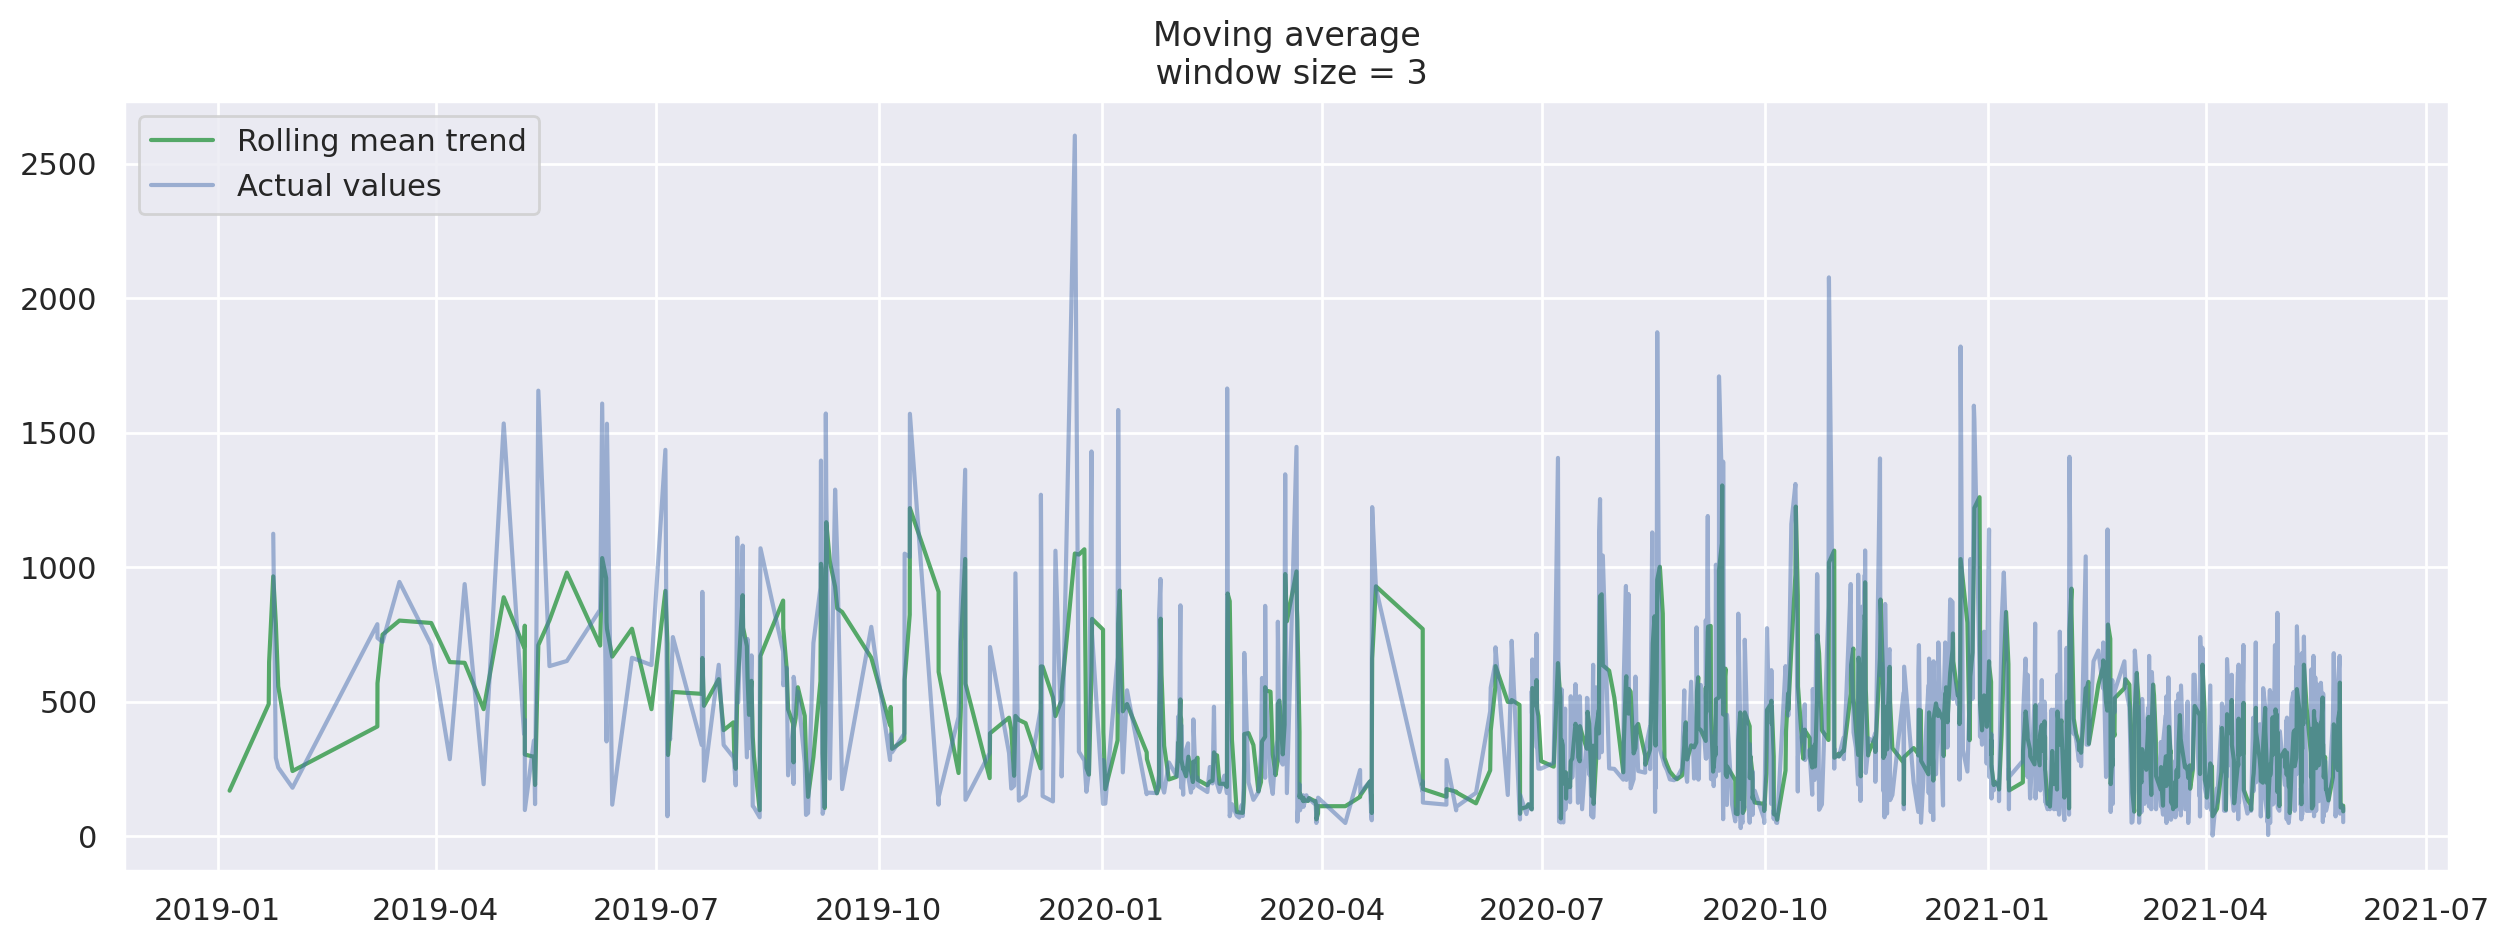

In [8]:
data_rm = plotMovingAverage(data, window=3, plot_graph=True)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
# Adding the lag of the target variable
for i in range(1, 10):
    data_rm["lag_{}".format(i)] = data_rm.y.shift(i)

In [27]:
X_rm = data_rm.dropna().drop(["y"], axis=1)
y_rm = data_rm.dropna().y
X_train_rm, X_test_rm, y_train_rm, y_test_rm = train_test_split(X_rm, y_rm, test_size=0.1, shuffle=False)

In [28]:
y_train_rm

created_at_utc
2019-03-10 00:46:24    749.000000
2019-03-16 23:52:39    801.333333
2019-03-30 03:21:18    792.333333
2019-04-06 19:02:26    647.000000
2019-04-12 22:34:50    644.333333
                          ...    
2021-04-24 18:33:01    340.083333
2021-04-25 14:21:00    476.533333
2021-04-25 16:41:04    389.700000
2021-04-26 09:50:20    234.033333
2021-04-26 10:09:02    223.650000
Name: y, Length: 794, dtype: float64

In [29]:
lr = LinearRegression()
lr.fit(X_train_rm, y_train_rm)

LinearRegression()

In [30]:
lr

LinearRegression()

In [31]:
def plotModelResults(
    model, X_train, y_train, X_test, y_test, plot_intervals=False, plot_anomalies=False
):
    """
        Plots modelled vs fact values, prediction intervals and anomalies

    """

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(np.array(y_test_rm.index), prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(np.array(y_test_rm.index), y_test.values, label="actual", alpha=0.5, linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(
            model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error"
        )
        mae = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN] * len(y_test))
            anomalies[y_test < lower] = y_test[y_test < lower]
            anomalies[y_test > upper] = y_test[y_test > upper]
            plt.plot(anomalies, "o", markersize=10, label="Anomalies")

    error = mean_absolute_percentage_error(y_test, prediction)
    error_r2 = r2_score(prediction, y_test)
    #plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.title("R2 score {0:.2f}".format(error_r2)+' and Mean absolute percentage error {0:.2f}%'.format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model, X_train):
    """
        Plots sorted coefficient values of the model
    """

    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind="bar")
    plt.grid(True, axis="y")
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles="dashed");

In [32]:
y_test_rm.index

DatetimeIndex(['2021-04-26 11:55:23', '2021-04-26 17:16:19',
               '2021-04-26 19:44:15', '2021-04-26 19:53:21',
               '2021-04-27 13:05:48', '2021-04-27 15:35:24',
               '2021-04-27 15:37:12', '2021-04-27 18:33:41',
               '2021-04-28 12:05:04', '2021-04-28 16:28:33',
               '2021-04-28 19:41:06', '2021-04-29 15:47:03',
               '2021-04-29 19:01:05', '2021-04-29 20:53:26',
               '2021-04-30 08:04:10', '2021-04-30 10:06:40',
               '2021-04-30 10:49:35', '2021-04-30 15:02:31',
               '2021-04-30 15:38:16', '2021-04-30 17:10:03',
               '2021-04-30 19:21:21', '2021-05-01 11:02:13',
               '2021-05-01 13:24:19', '2021-05-01 15:47:22',
               '2021-05-03 17:28:55', '2021-05-03 19:28:17',
               '2021-05-04 09:20:26', '2021-05-04 11:44:54',
               '2021-05-04 14:32:12', '2021-05-05 07:42:49',
               '2021-05-05 15:46:07', '2021-05-05 18:20:53',
               '2021-05-

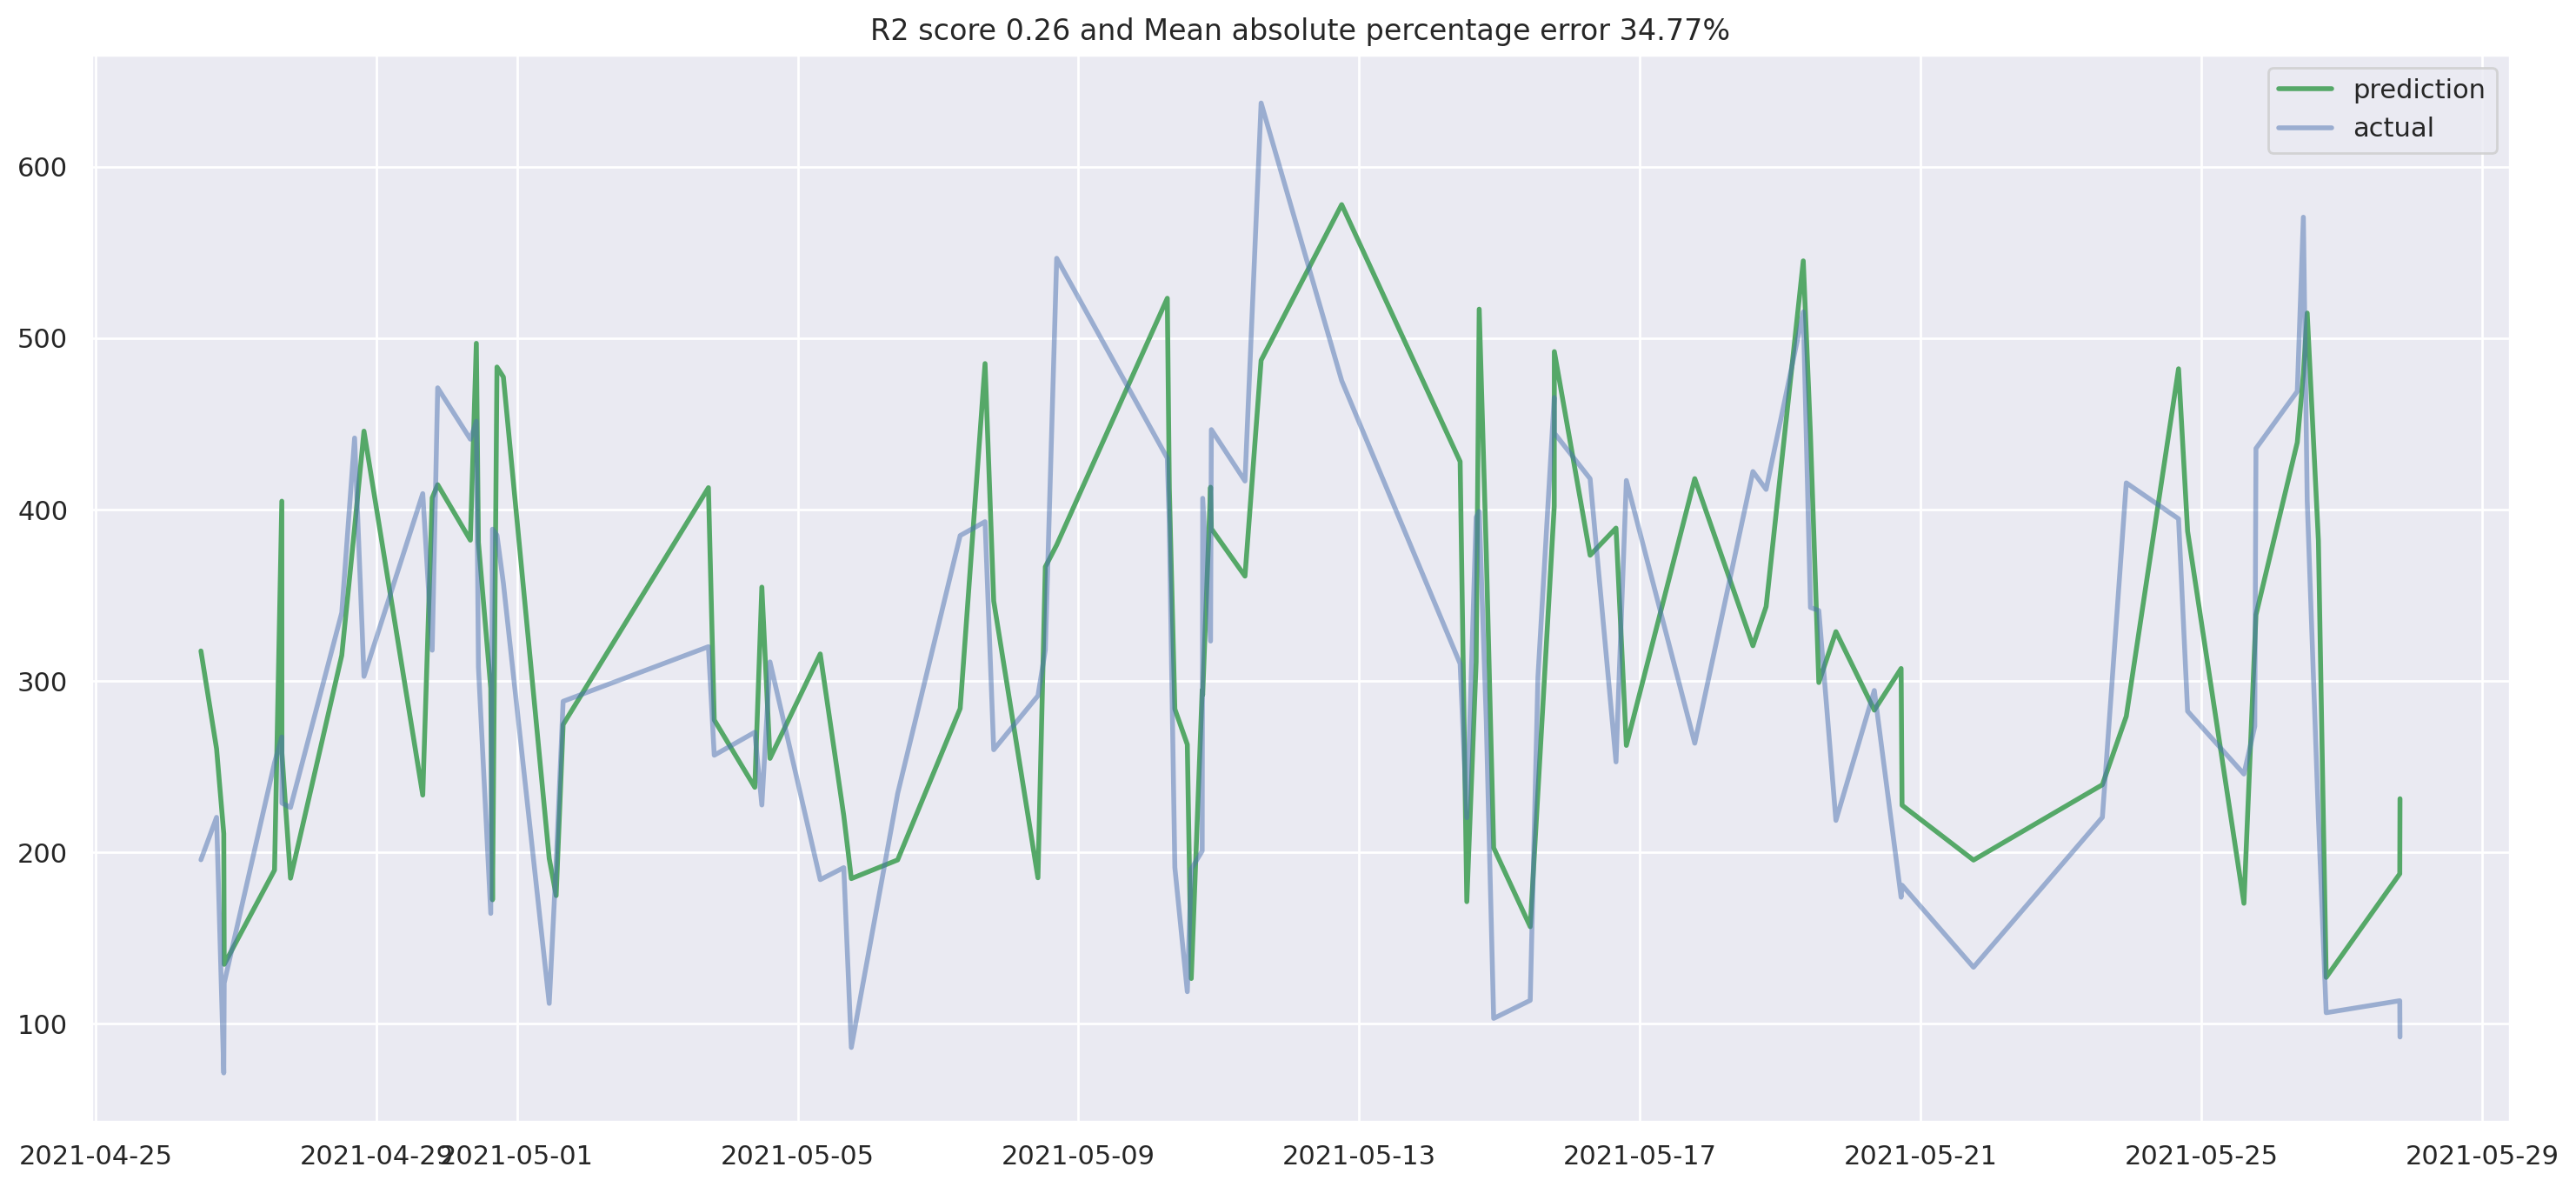

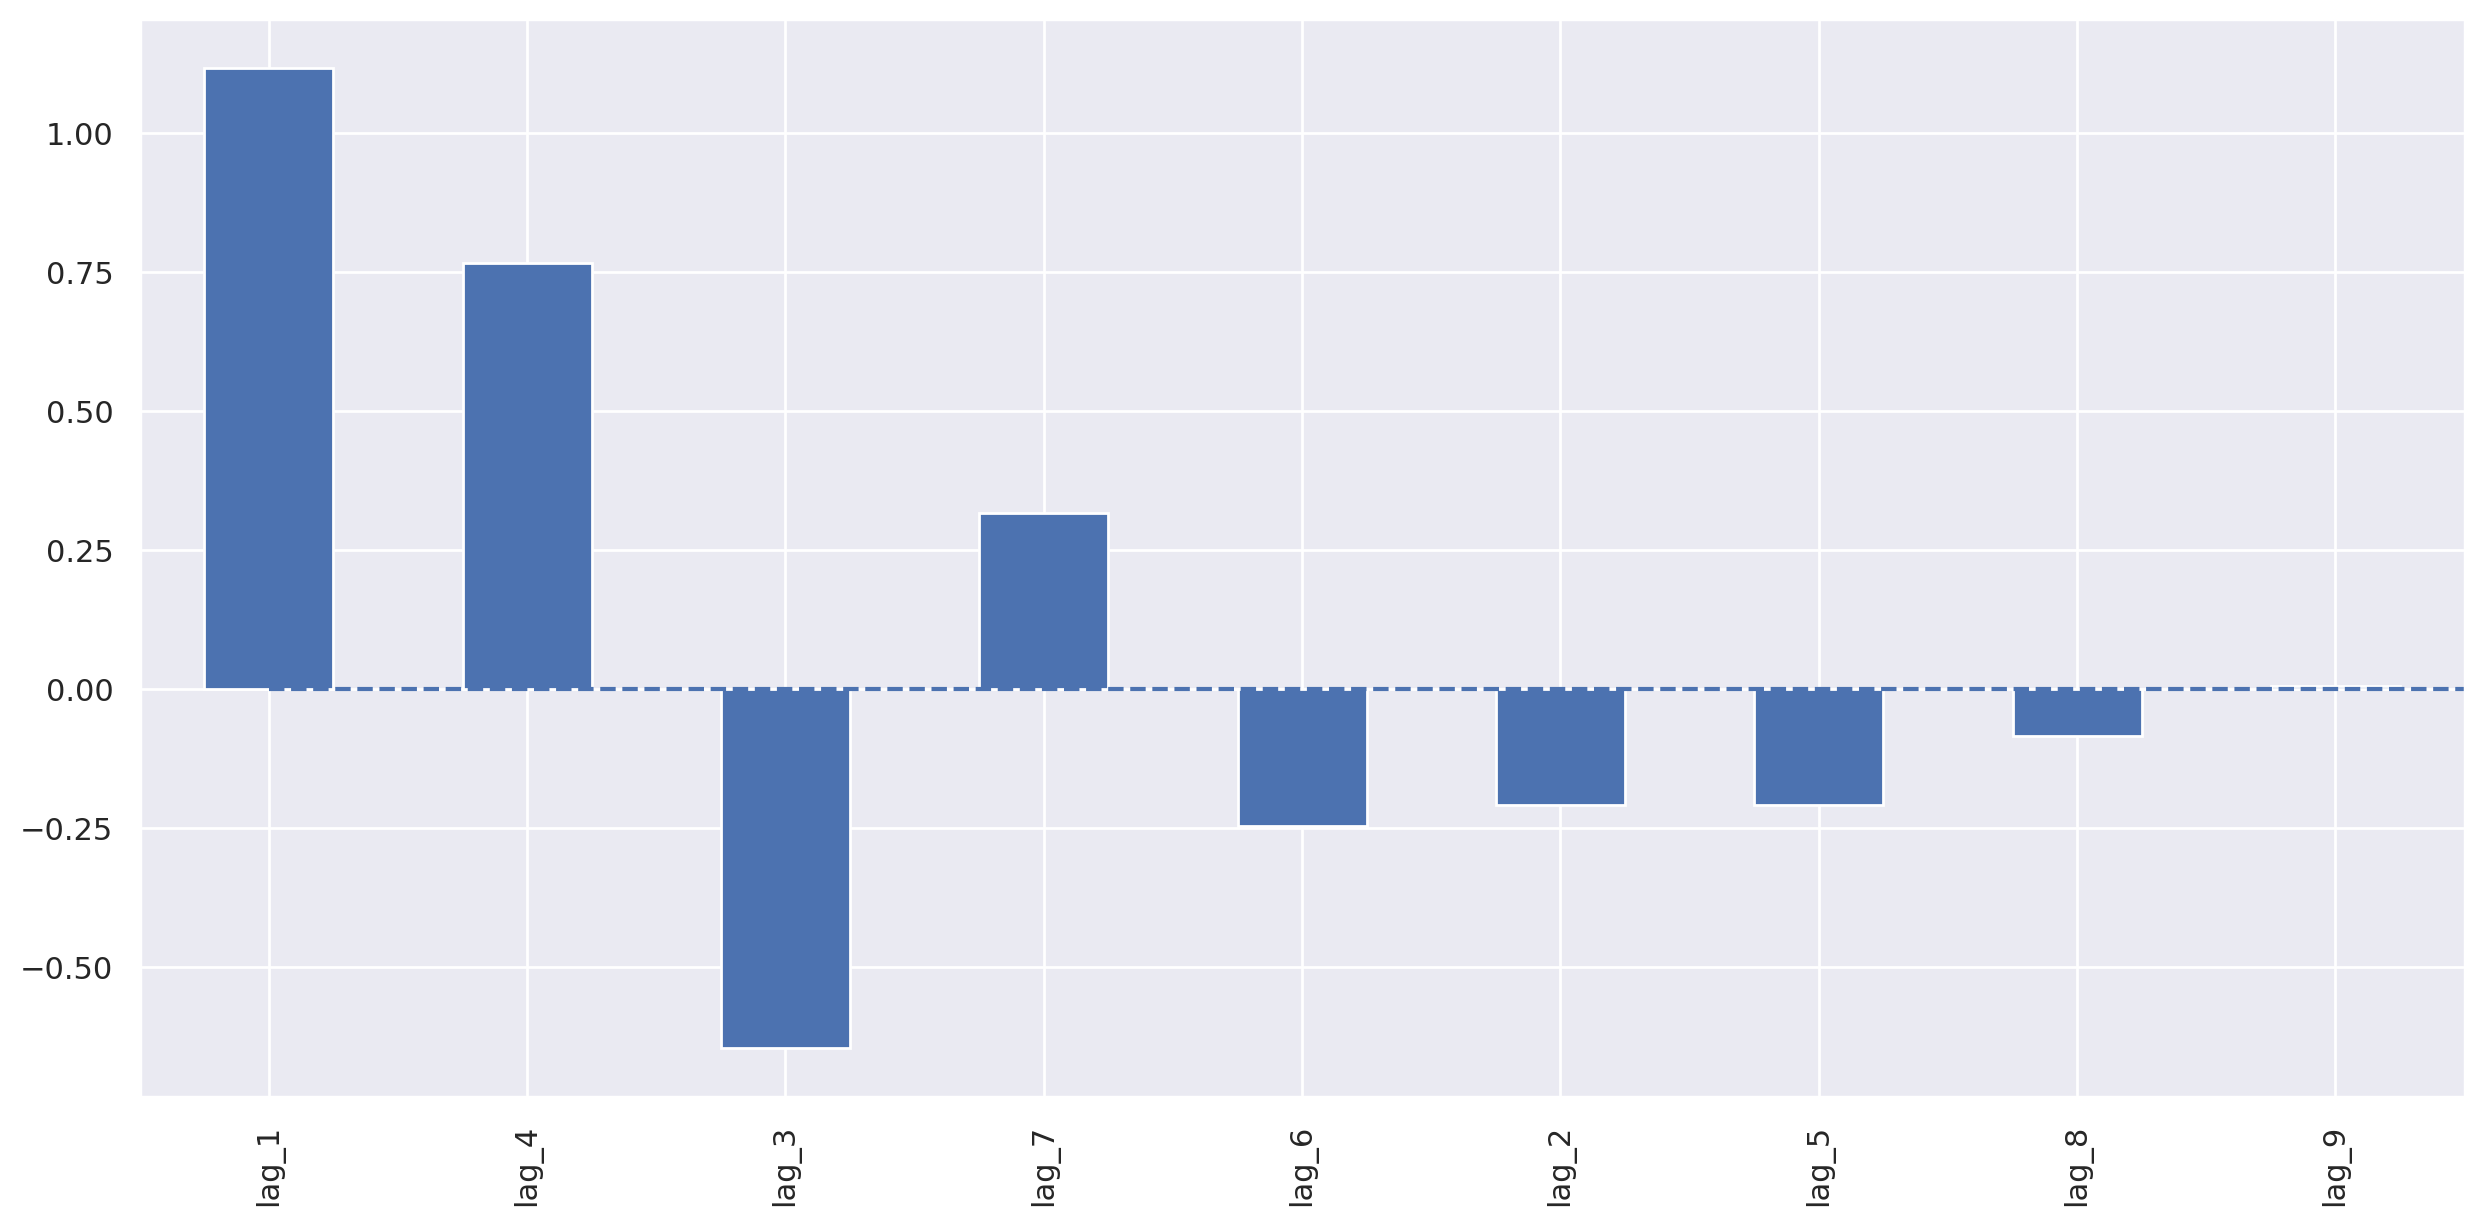

In [33]:
plotModelResults(lr, X_train_rm, y_train_rm, X_test_rm, y_test_rm)
plotCoefficients(lr, X_train_rm)

In [45]:
y_train_rm.index()

TypeError: 'DatetimeIndex' object is not callable

In [16]:
data_rm.index = pd.to_datetime(data_rm.index)
data_rm["hour"] = data_rm.index.hour
data_rm["weekday"] = data_rm.index.weekday
data_rm["is_weekend"] = data_rm.weekday.isin([5, 6]) * 1

In [17]:
X_rm = data_rm.dropna().drop(["y"], axis=1)
y_rm = data_rm.dropna().y
X_train_rm, X_test_rm, y_train_rm, y_test_rm = train_test_split(X_rm, y_rm, test_size=0.7, random_state=None)

In [18]:
lr = LinearRegression()
lr.fit(X_train_rm, y_train_rm)

LinearRegression()

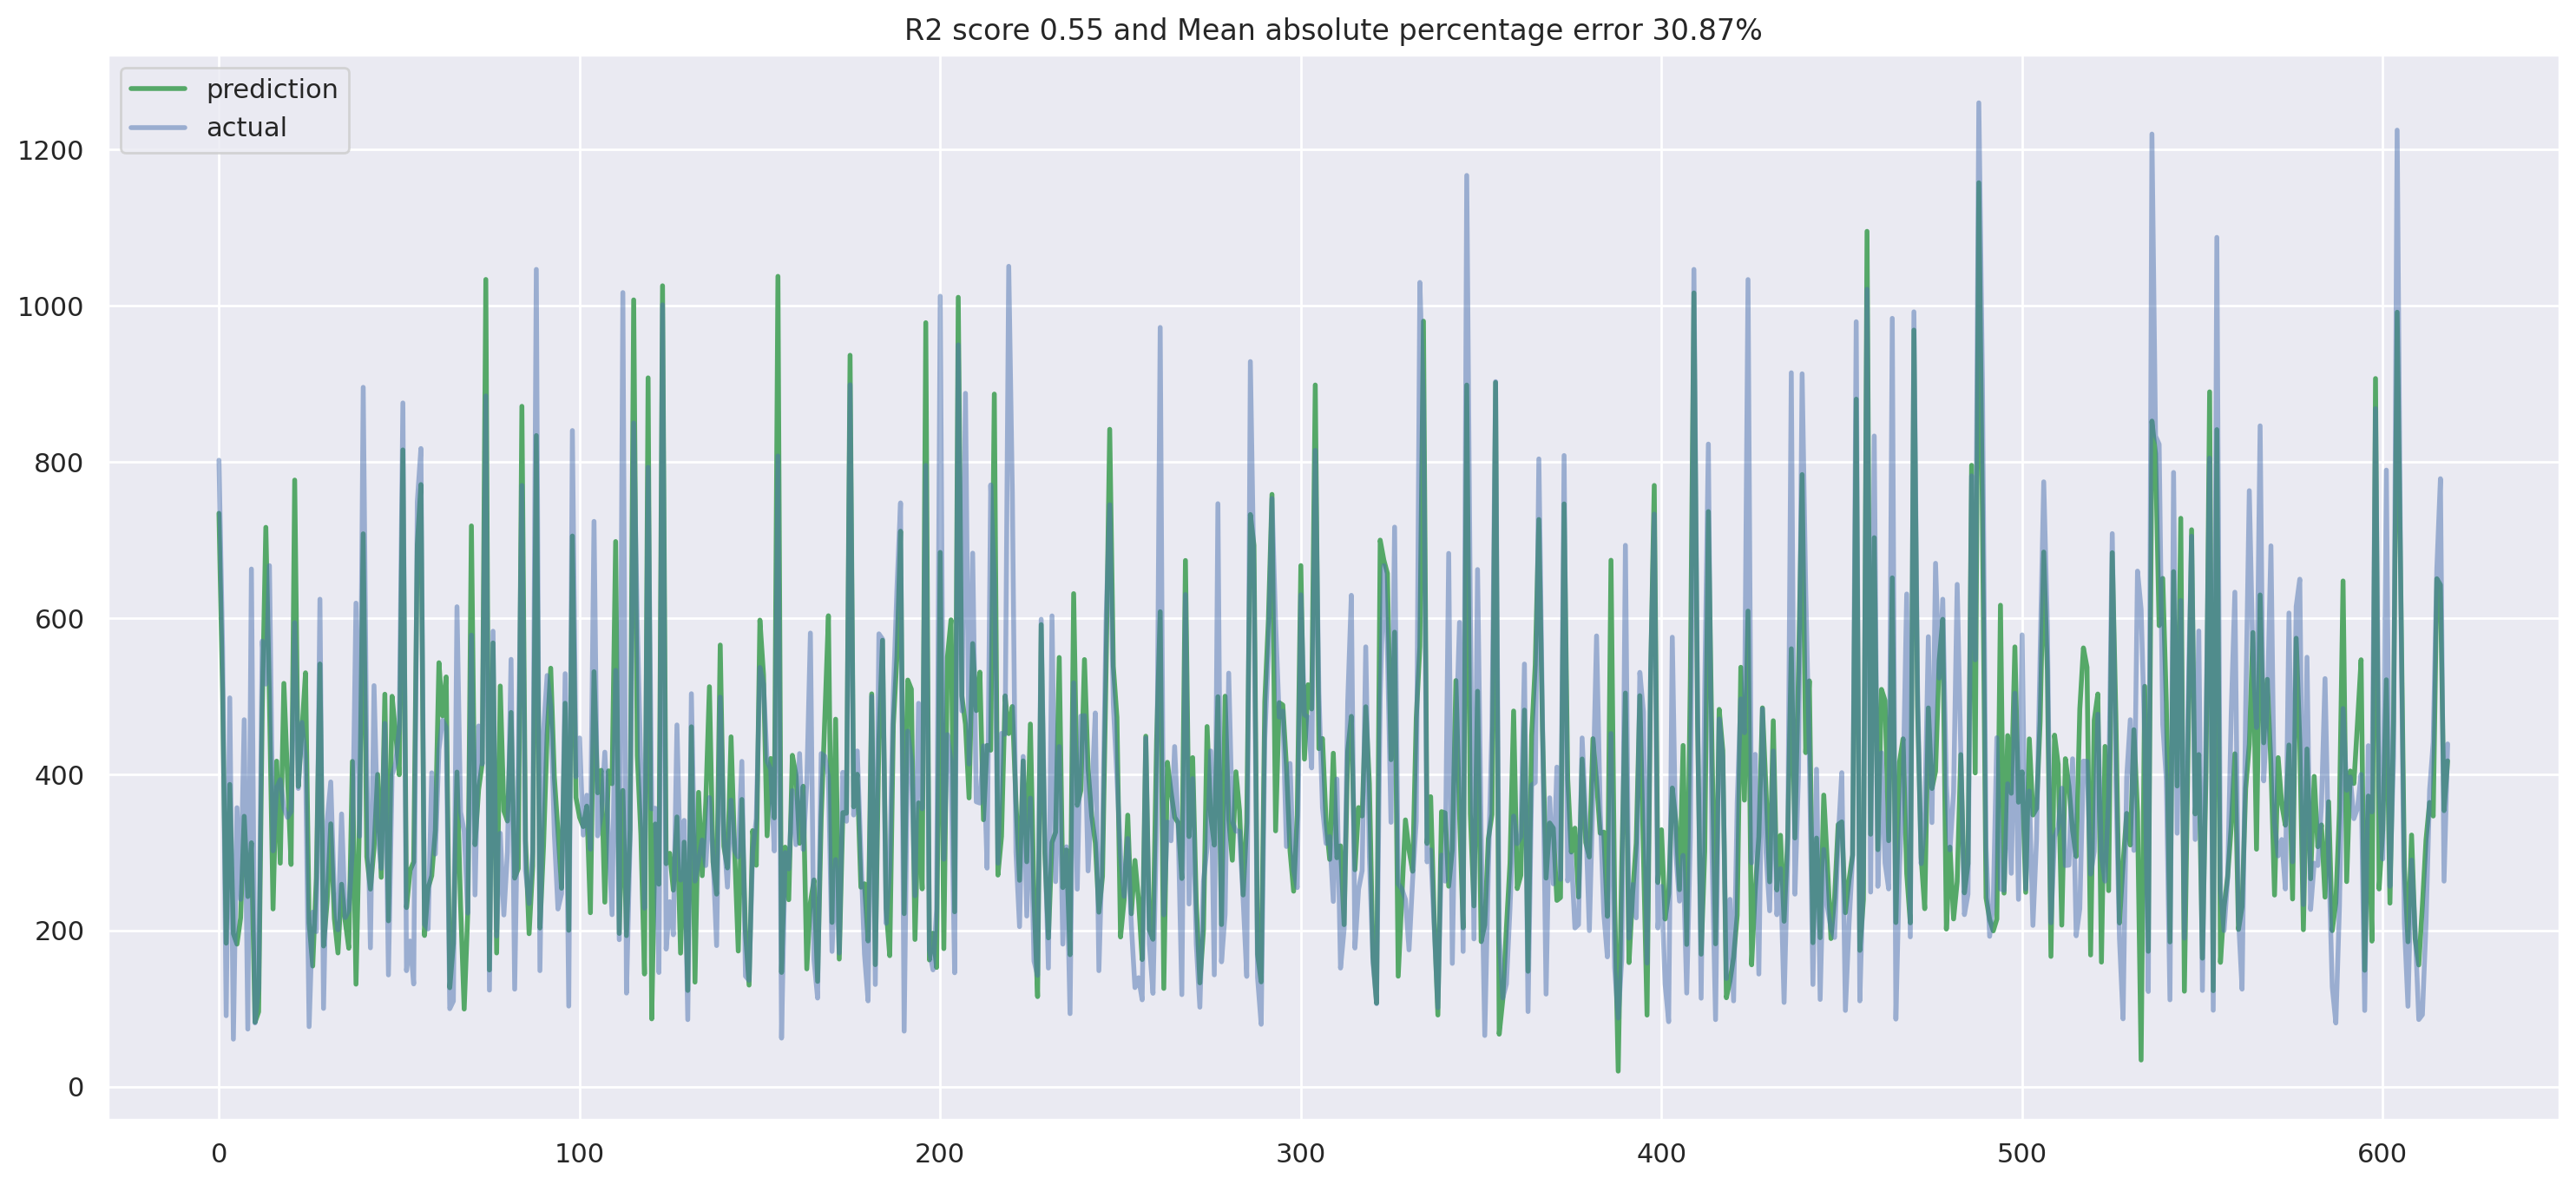

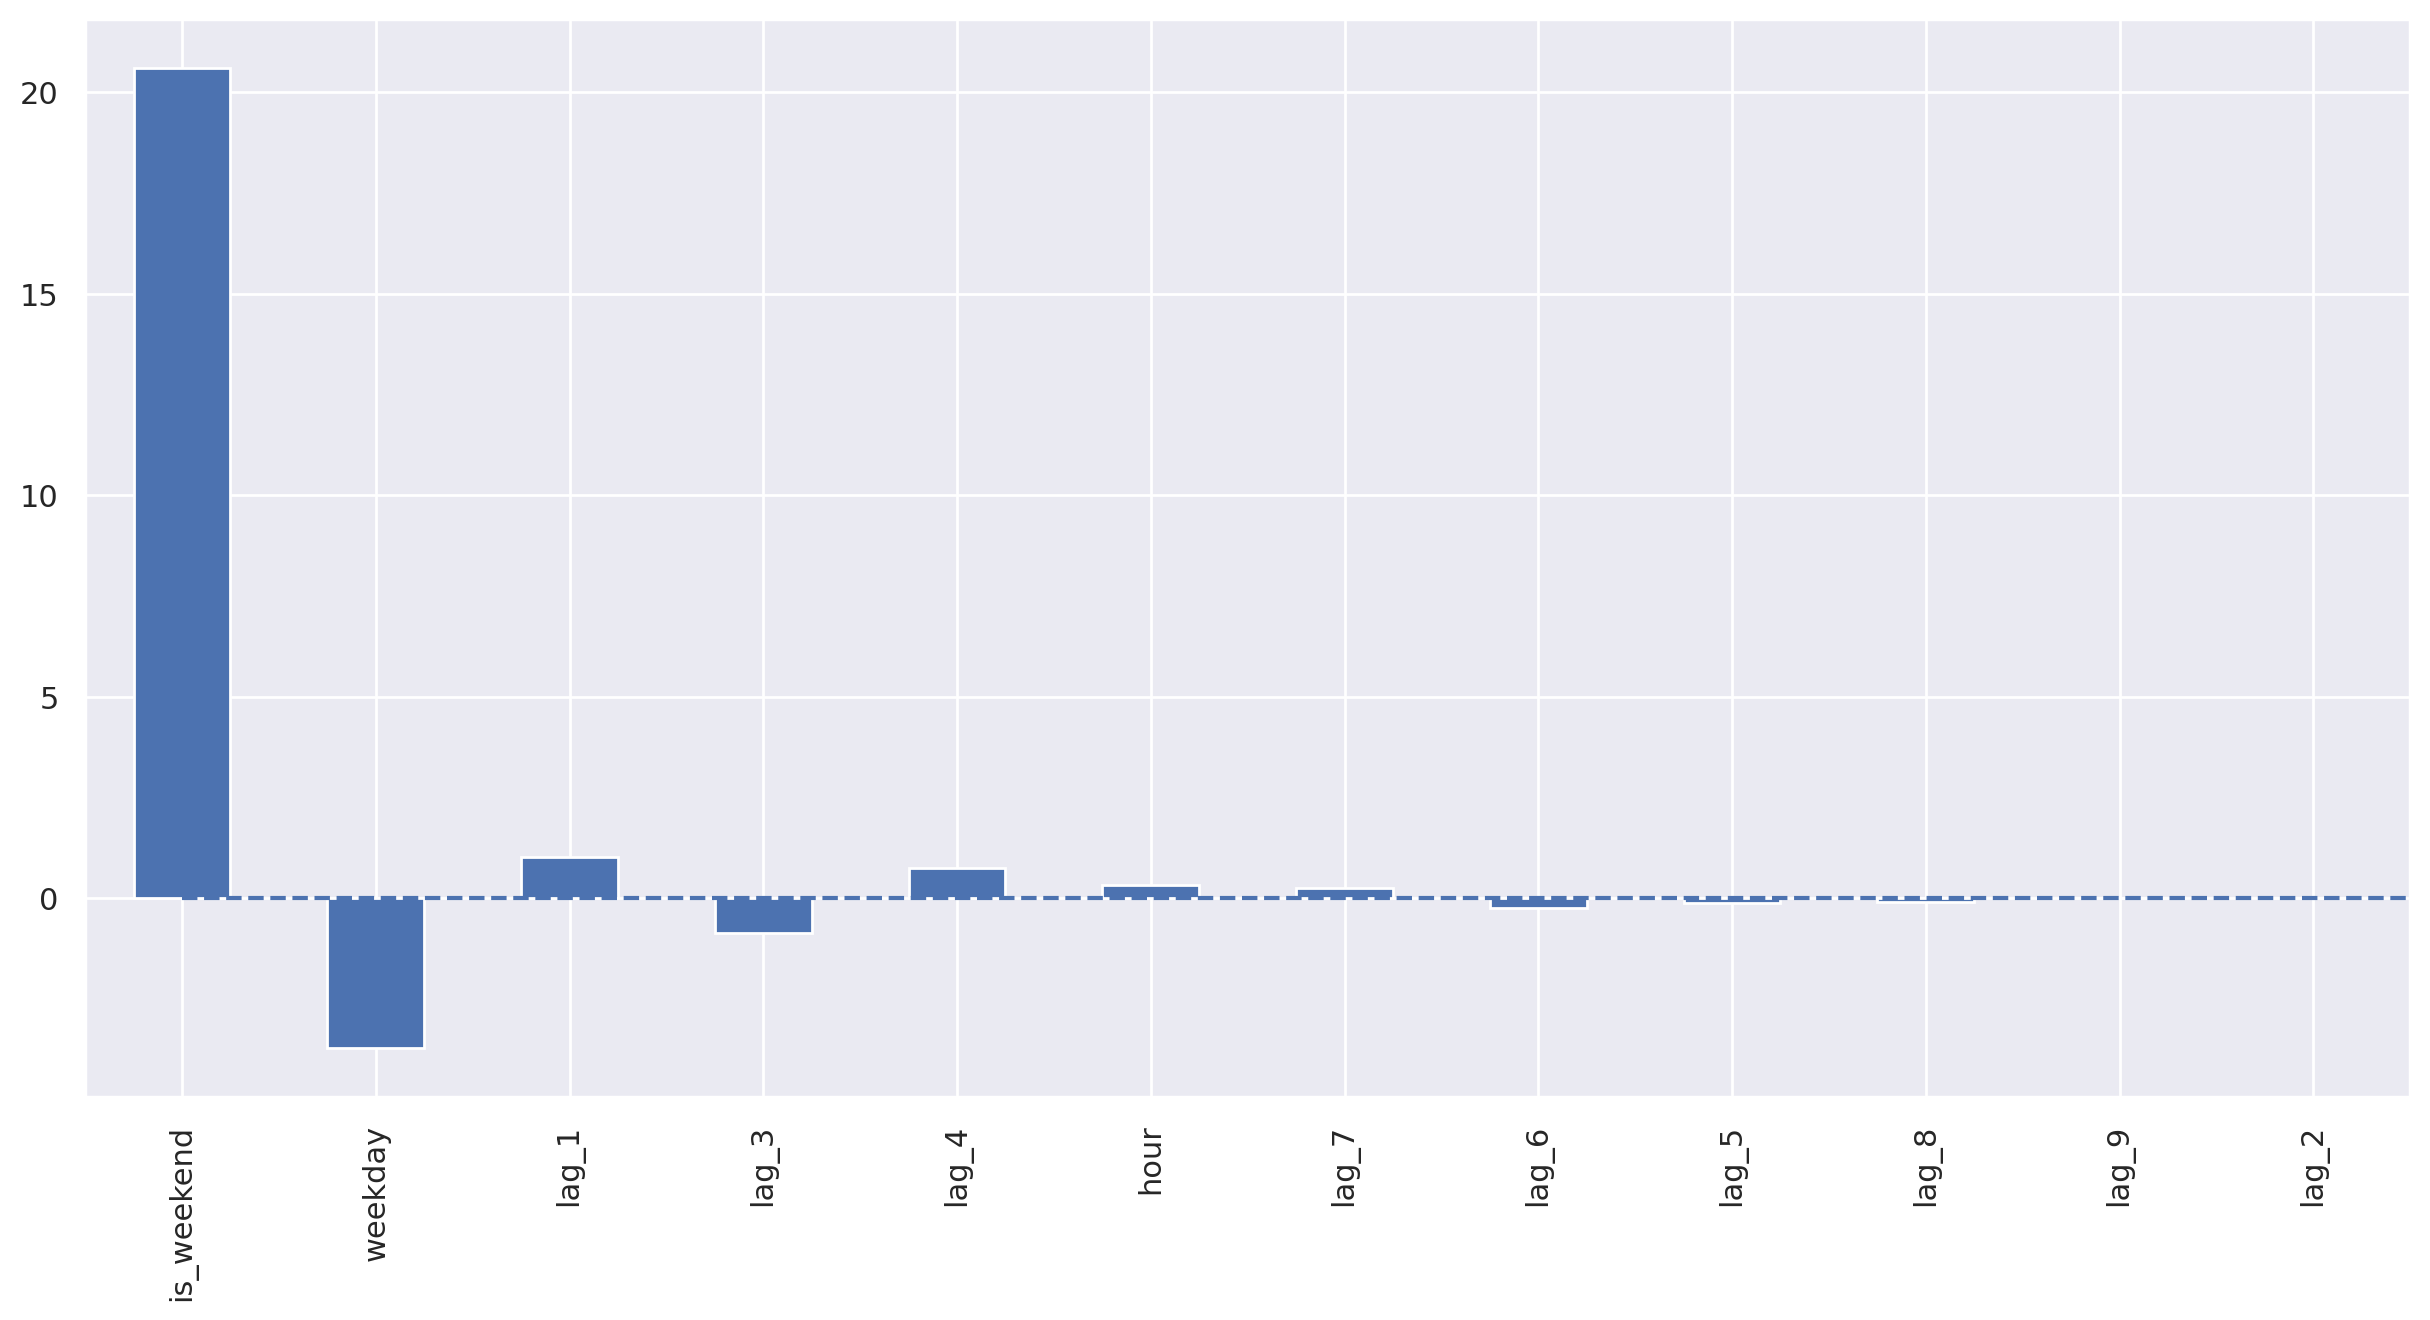

In [19]:
plotModelResults(lr, X_train_rm, y_train_rm, X_test_rm, y_test_rm)
plotCoefficients(lr, X_train_rm)

**Interestingly enough, our model did not improve from adding features of weekend and weekday**

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.pipeline import make_pipeline

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "MaxAbsScaler": MaxAbsScaler(),
    "RobustScaler": RobustScaler()
}

In [21]:
def evaluate_model(pipe, X, y):
    # Use cross-validation to evaluate the model
    scores = cross_val_score(pipe, X, y, cv=tscv, scoring='r2')
    return scores  # return the mean squared error

In [22]:
lr = LinearRegression()
for scaler_name, scaler in scalers.items():
    # Create a pipeline with the scaler and the model
    pipe = make_pipeline(scaler, lr)
    
    # Train and evaluate the model
    r2 = evaluate_model(pipe, X_train_rm, y_train_rm)
    
    # Print the results
    print(f"Scaler: {scaler_name}, r2: {r2}")

Scaler: StandardScaler, r2: [0.72899051 0.80871887 0.78041538 0.49989813 0.76263947]
Scaler: MinMaxScaler, r2: [0.72899051 0.80871887 0.78041538 0.49989813 0.76263947]
Scaler: MaxAbsScaler, r2: [0.72899051 0.80871887 0.78041538 0.49989813 0.76263947]
Scaler: RobustScaler, r2: [0.72899051 0.80871887 0.78041538 0.49989813 0.76263947]


In [23]:
best_scaler_name = "MinMaxScaler"  # Choose the best scaler based on the results
best_scaler = scalers[best_scaler_name]
best_pipe = make_pipeline(best_scaler, lr)
best_pipe.fit(X_train_rm, y_train_rm)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

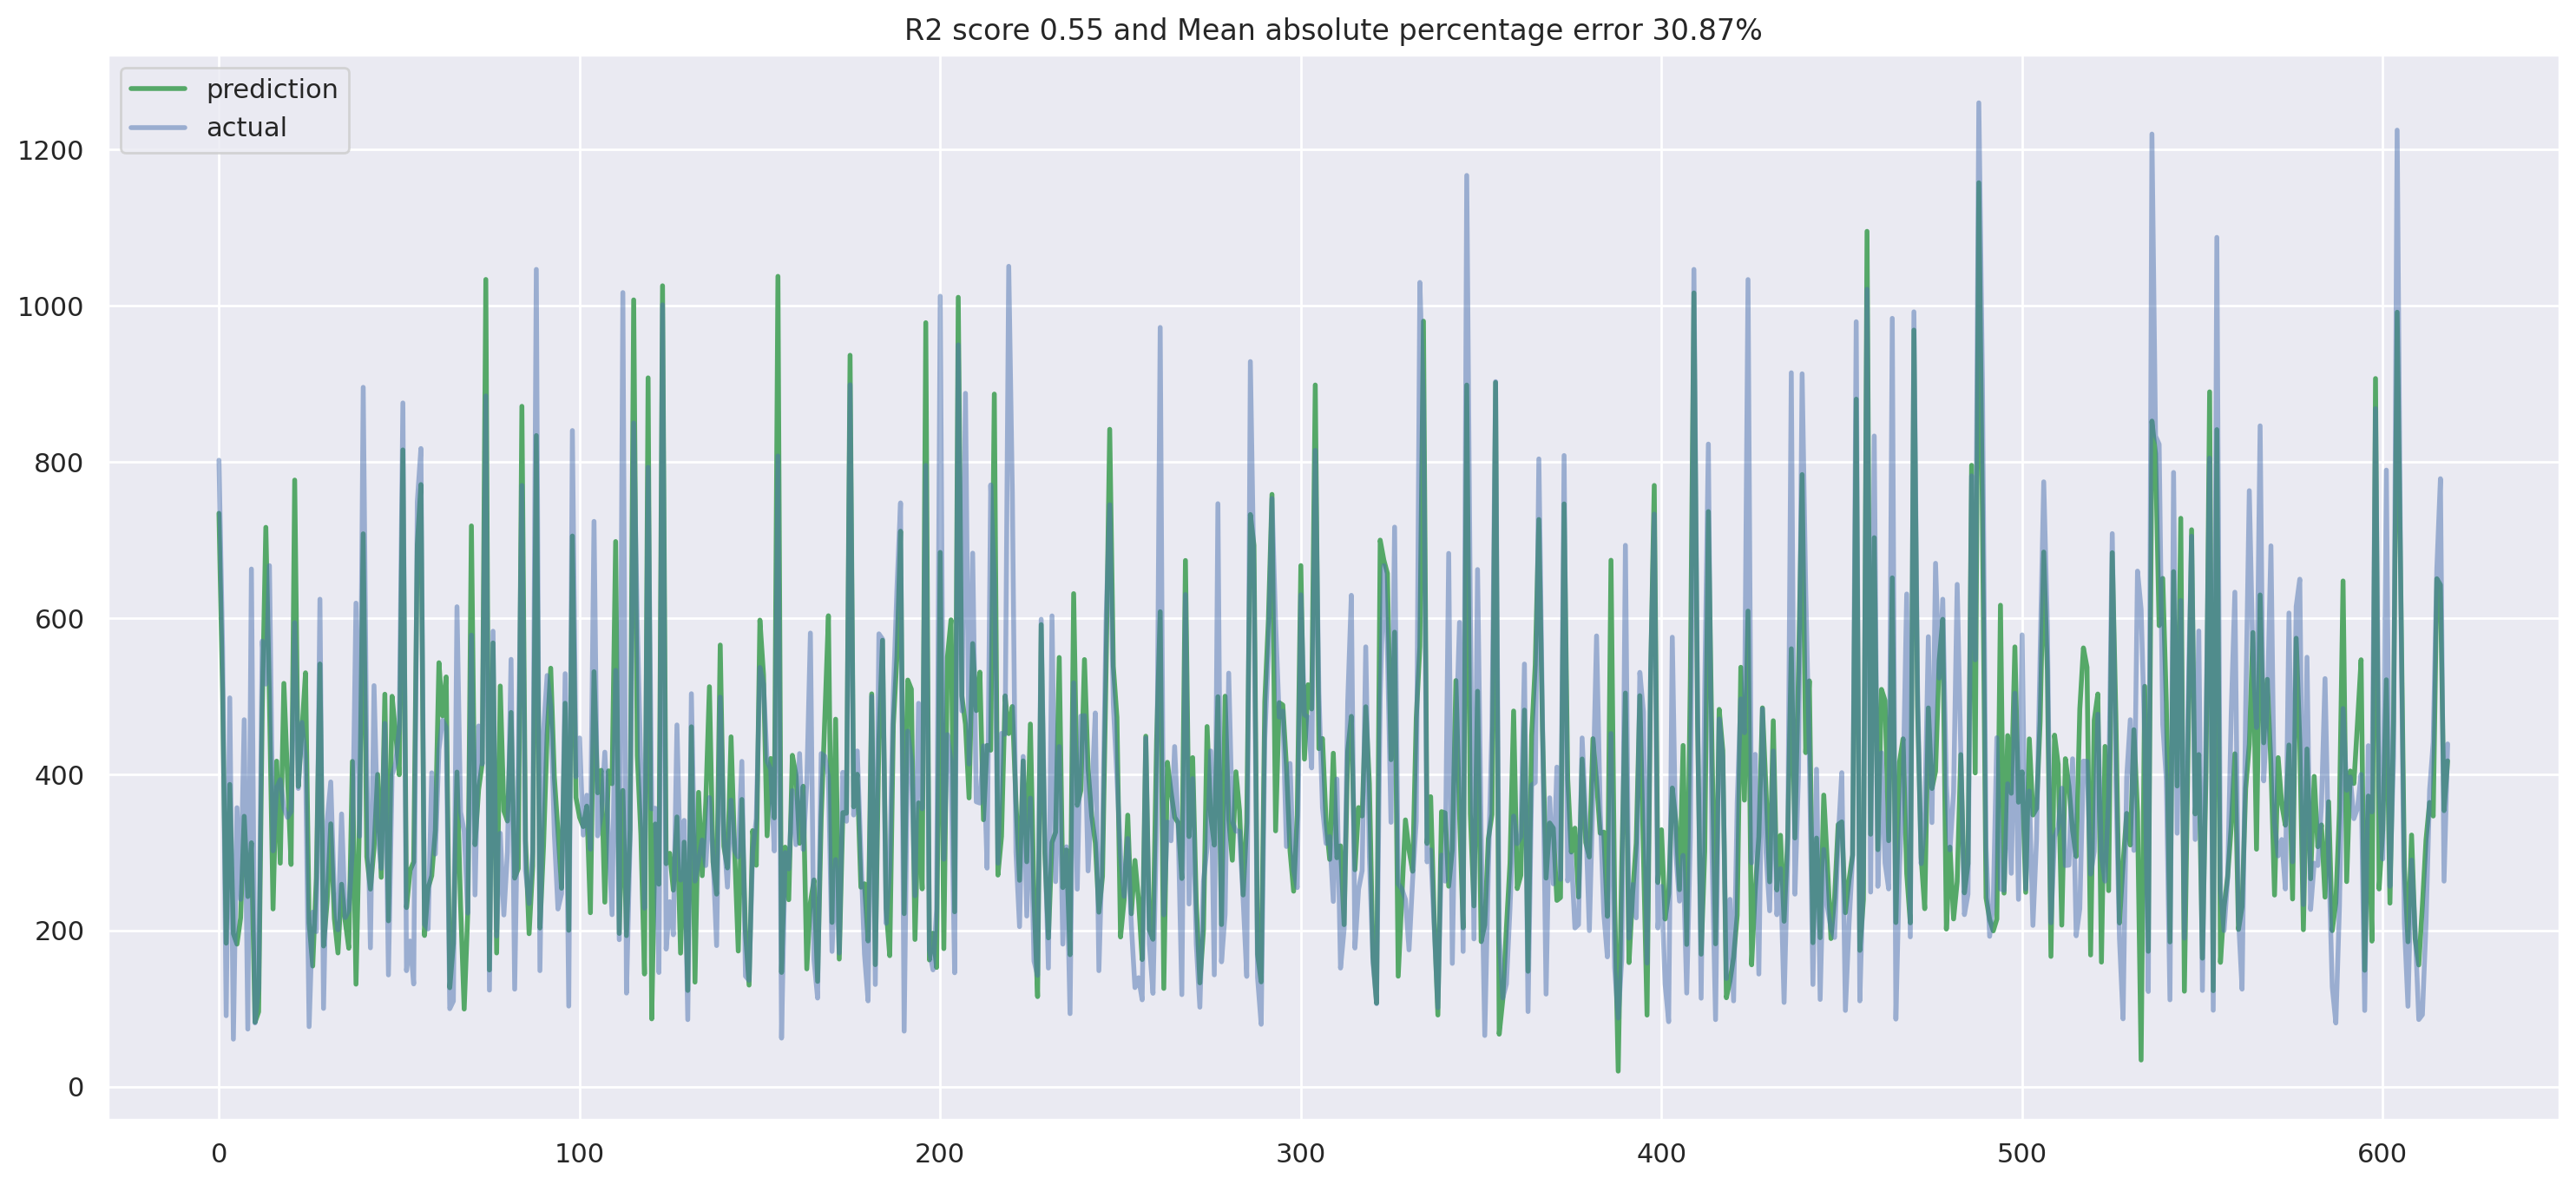

In [24]:
plotModelResults(best_pipe, X_train_rm, y_train_rm, X_test_rm, y_test_rm)
#plotCoefficients(best_pipe, X_train_rm)

**Our model does not need scalers to improve its accuracy, on avarage.**

In [25]:
### LassoCV and RidgeCV

In [26]:
from sklearn.linear_model import LassoCV, RidgeCV

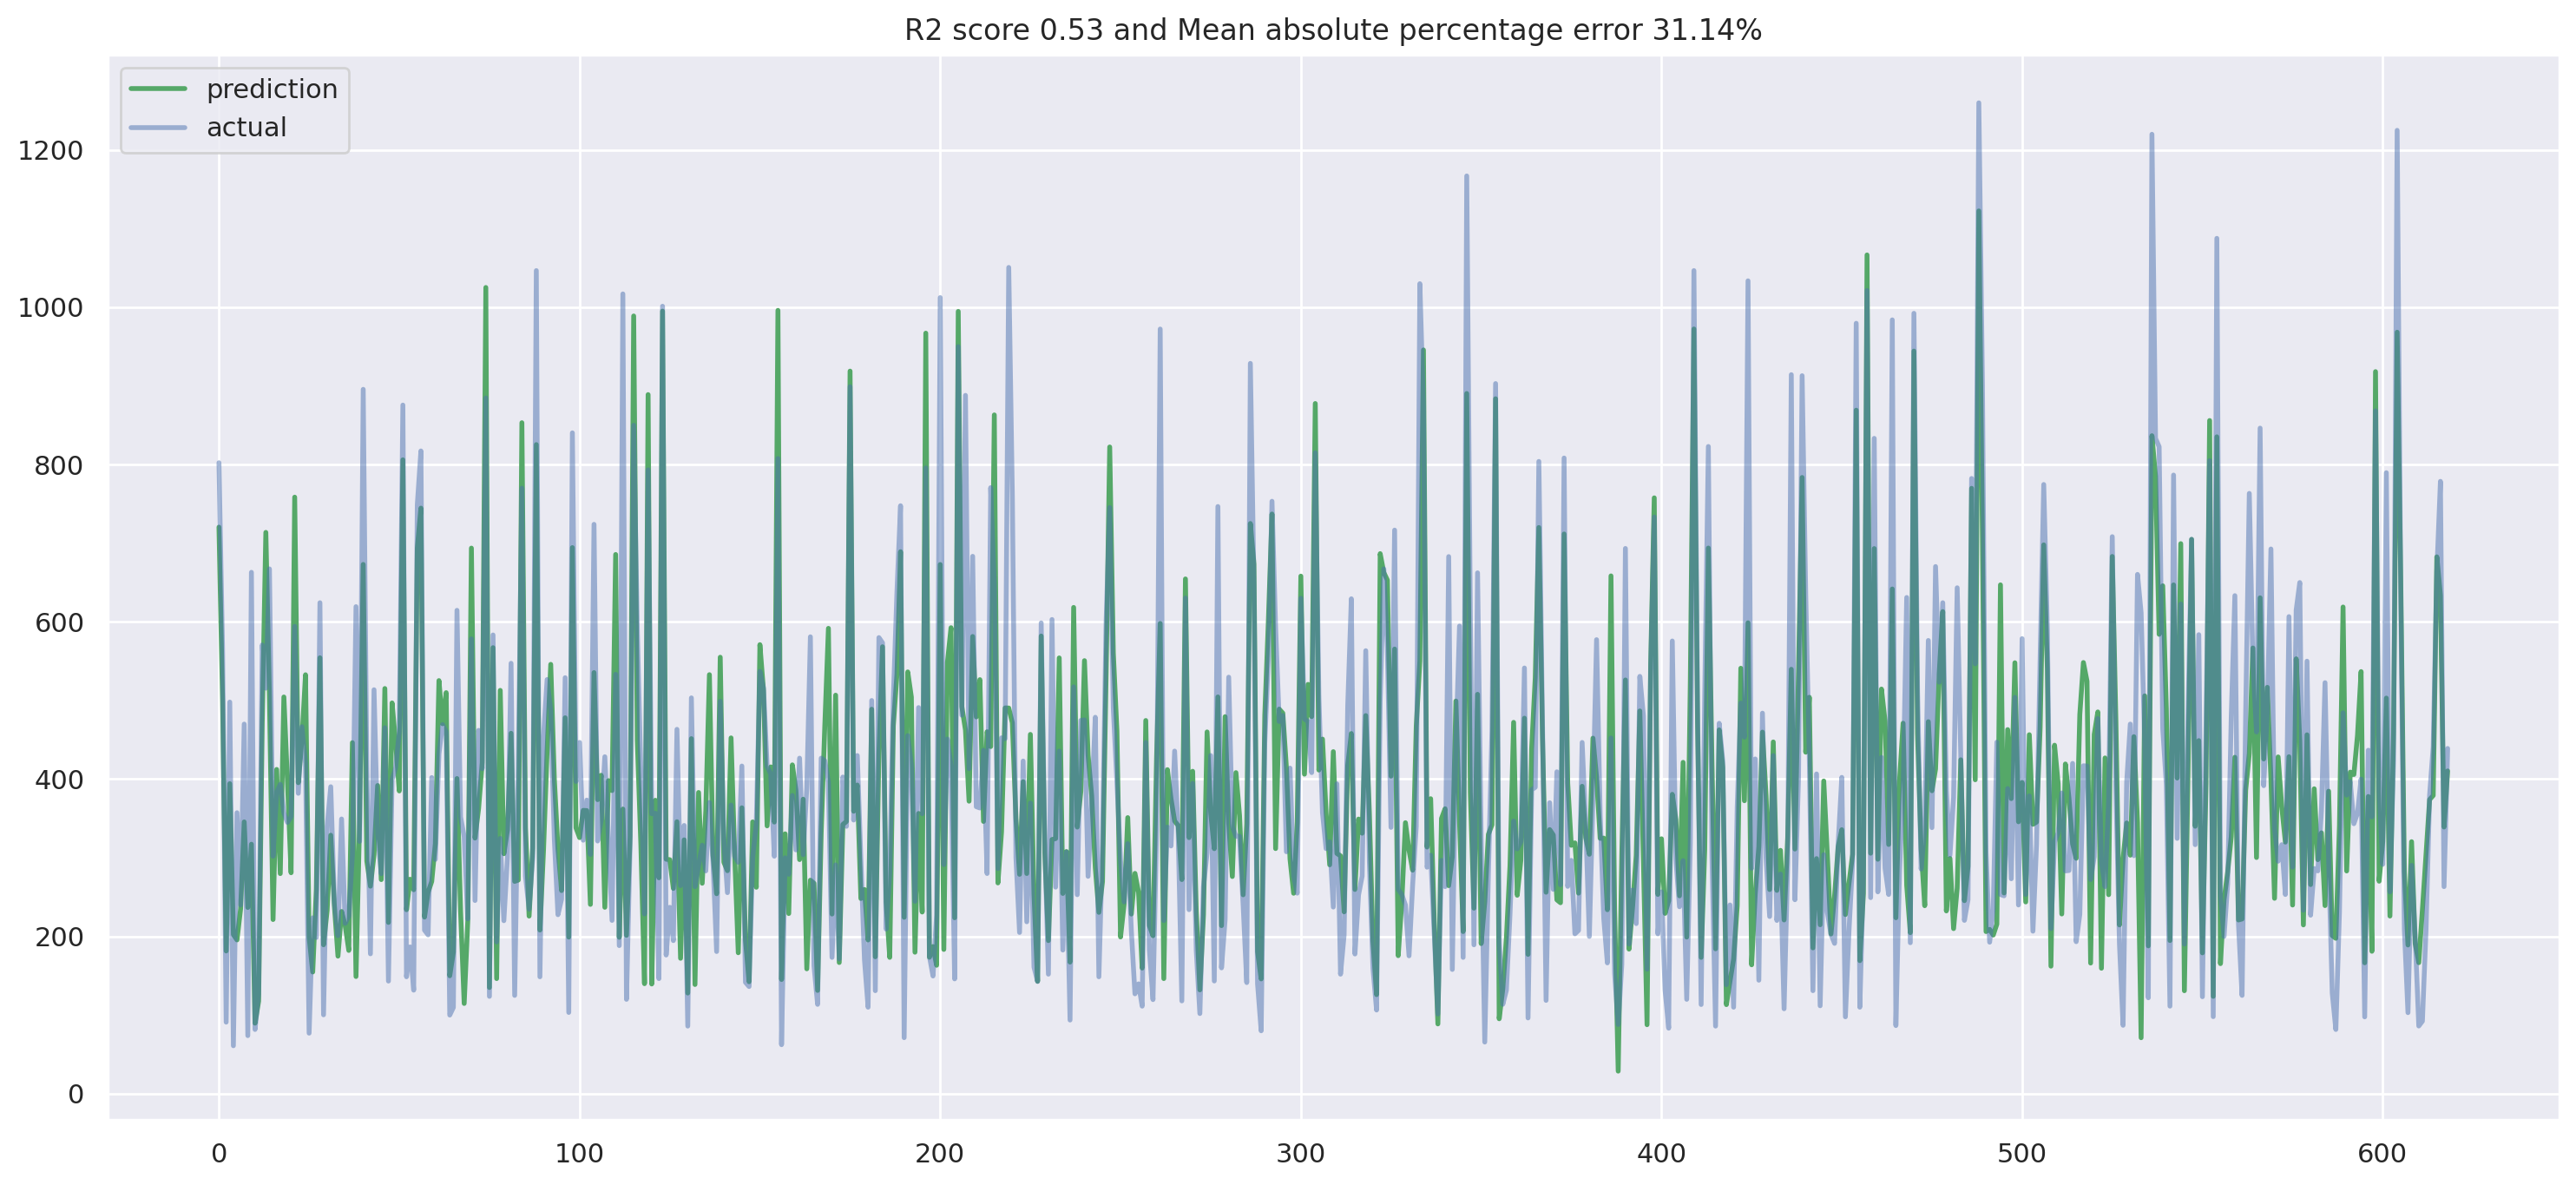

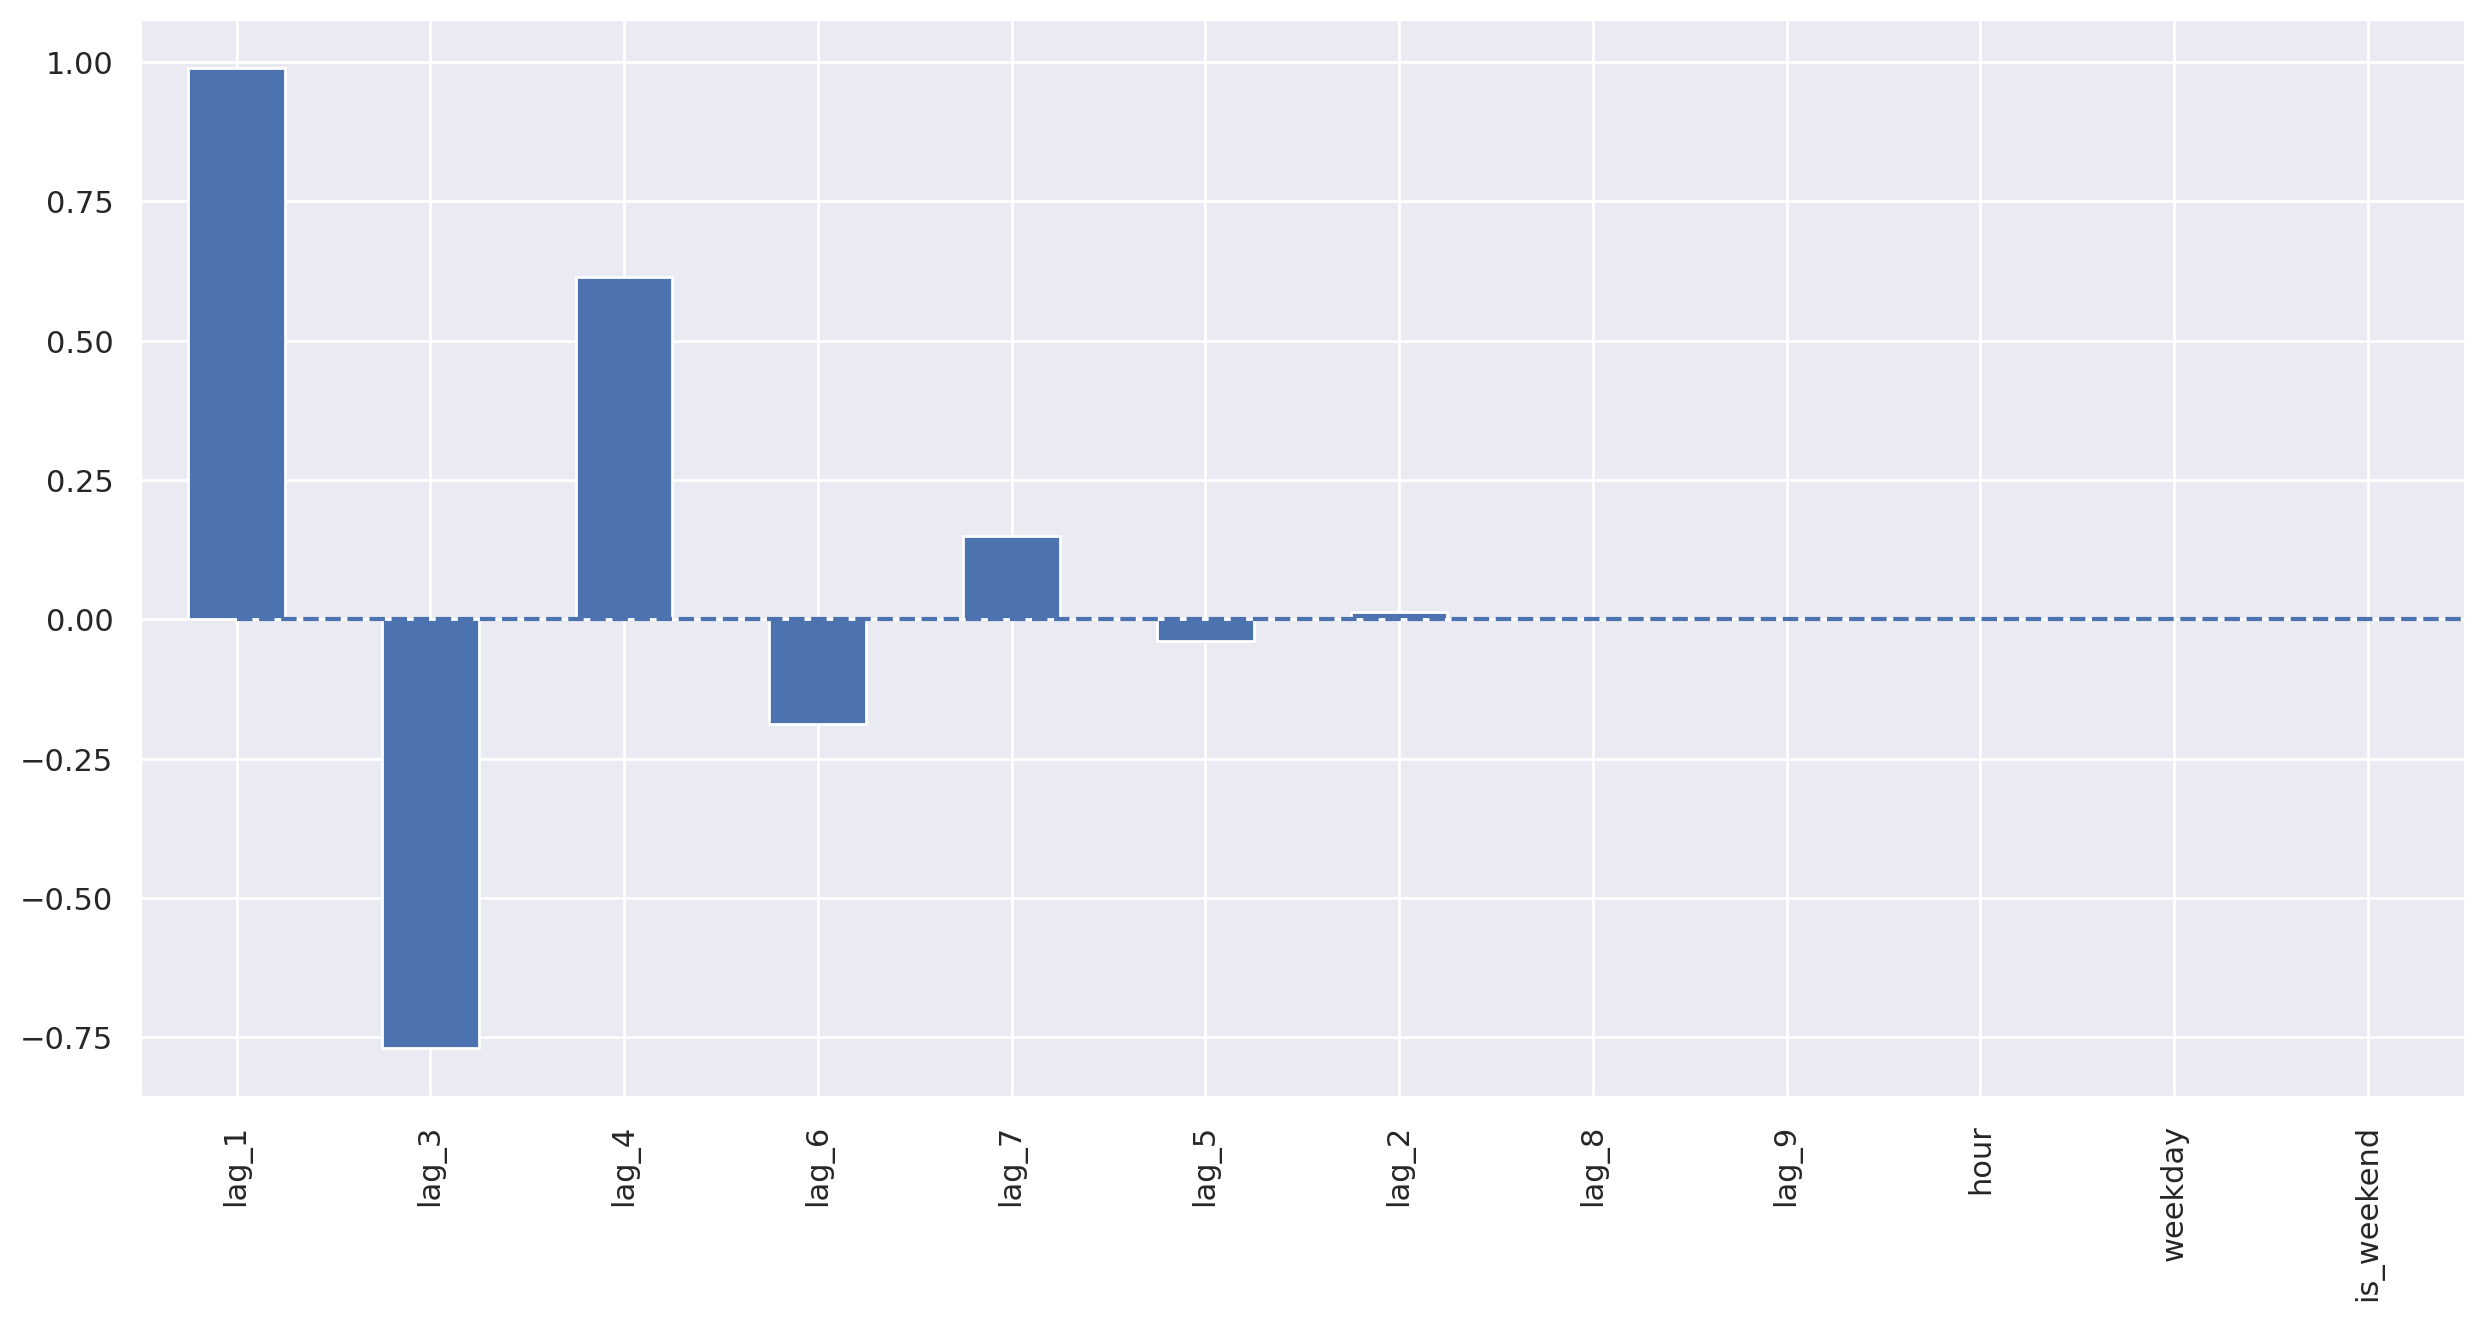

In [27]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_rm, y_train_rm)

plotModelResults(
    lasso,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)
plotCoefficients(lasso, X_train_rm)

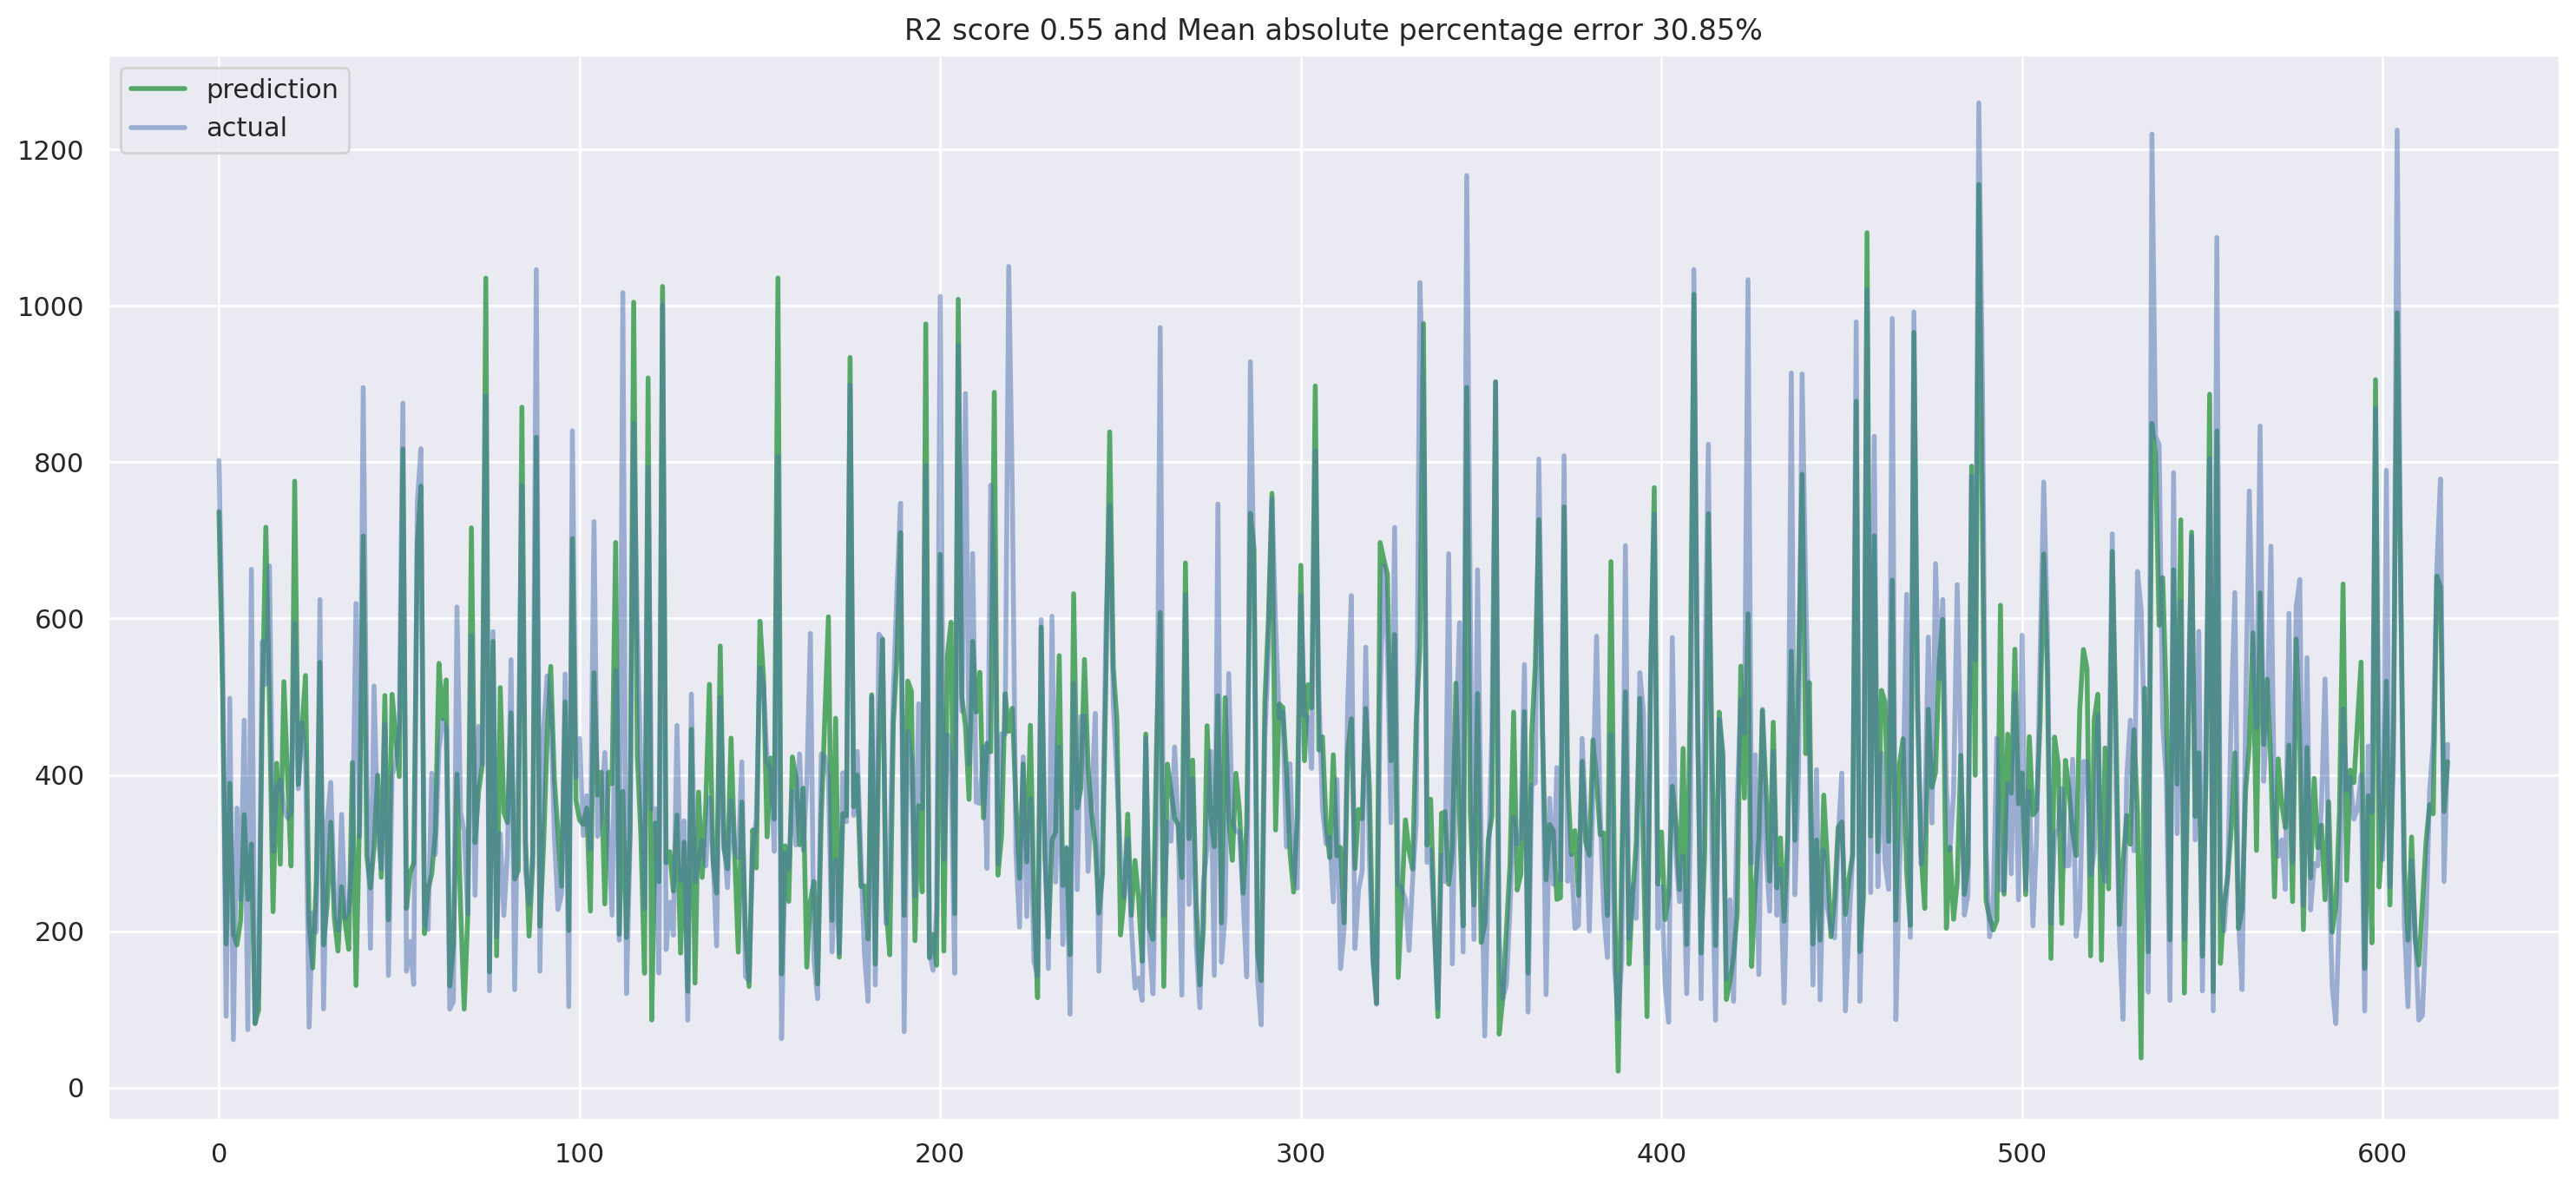

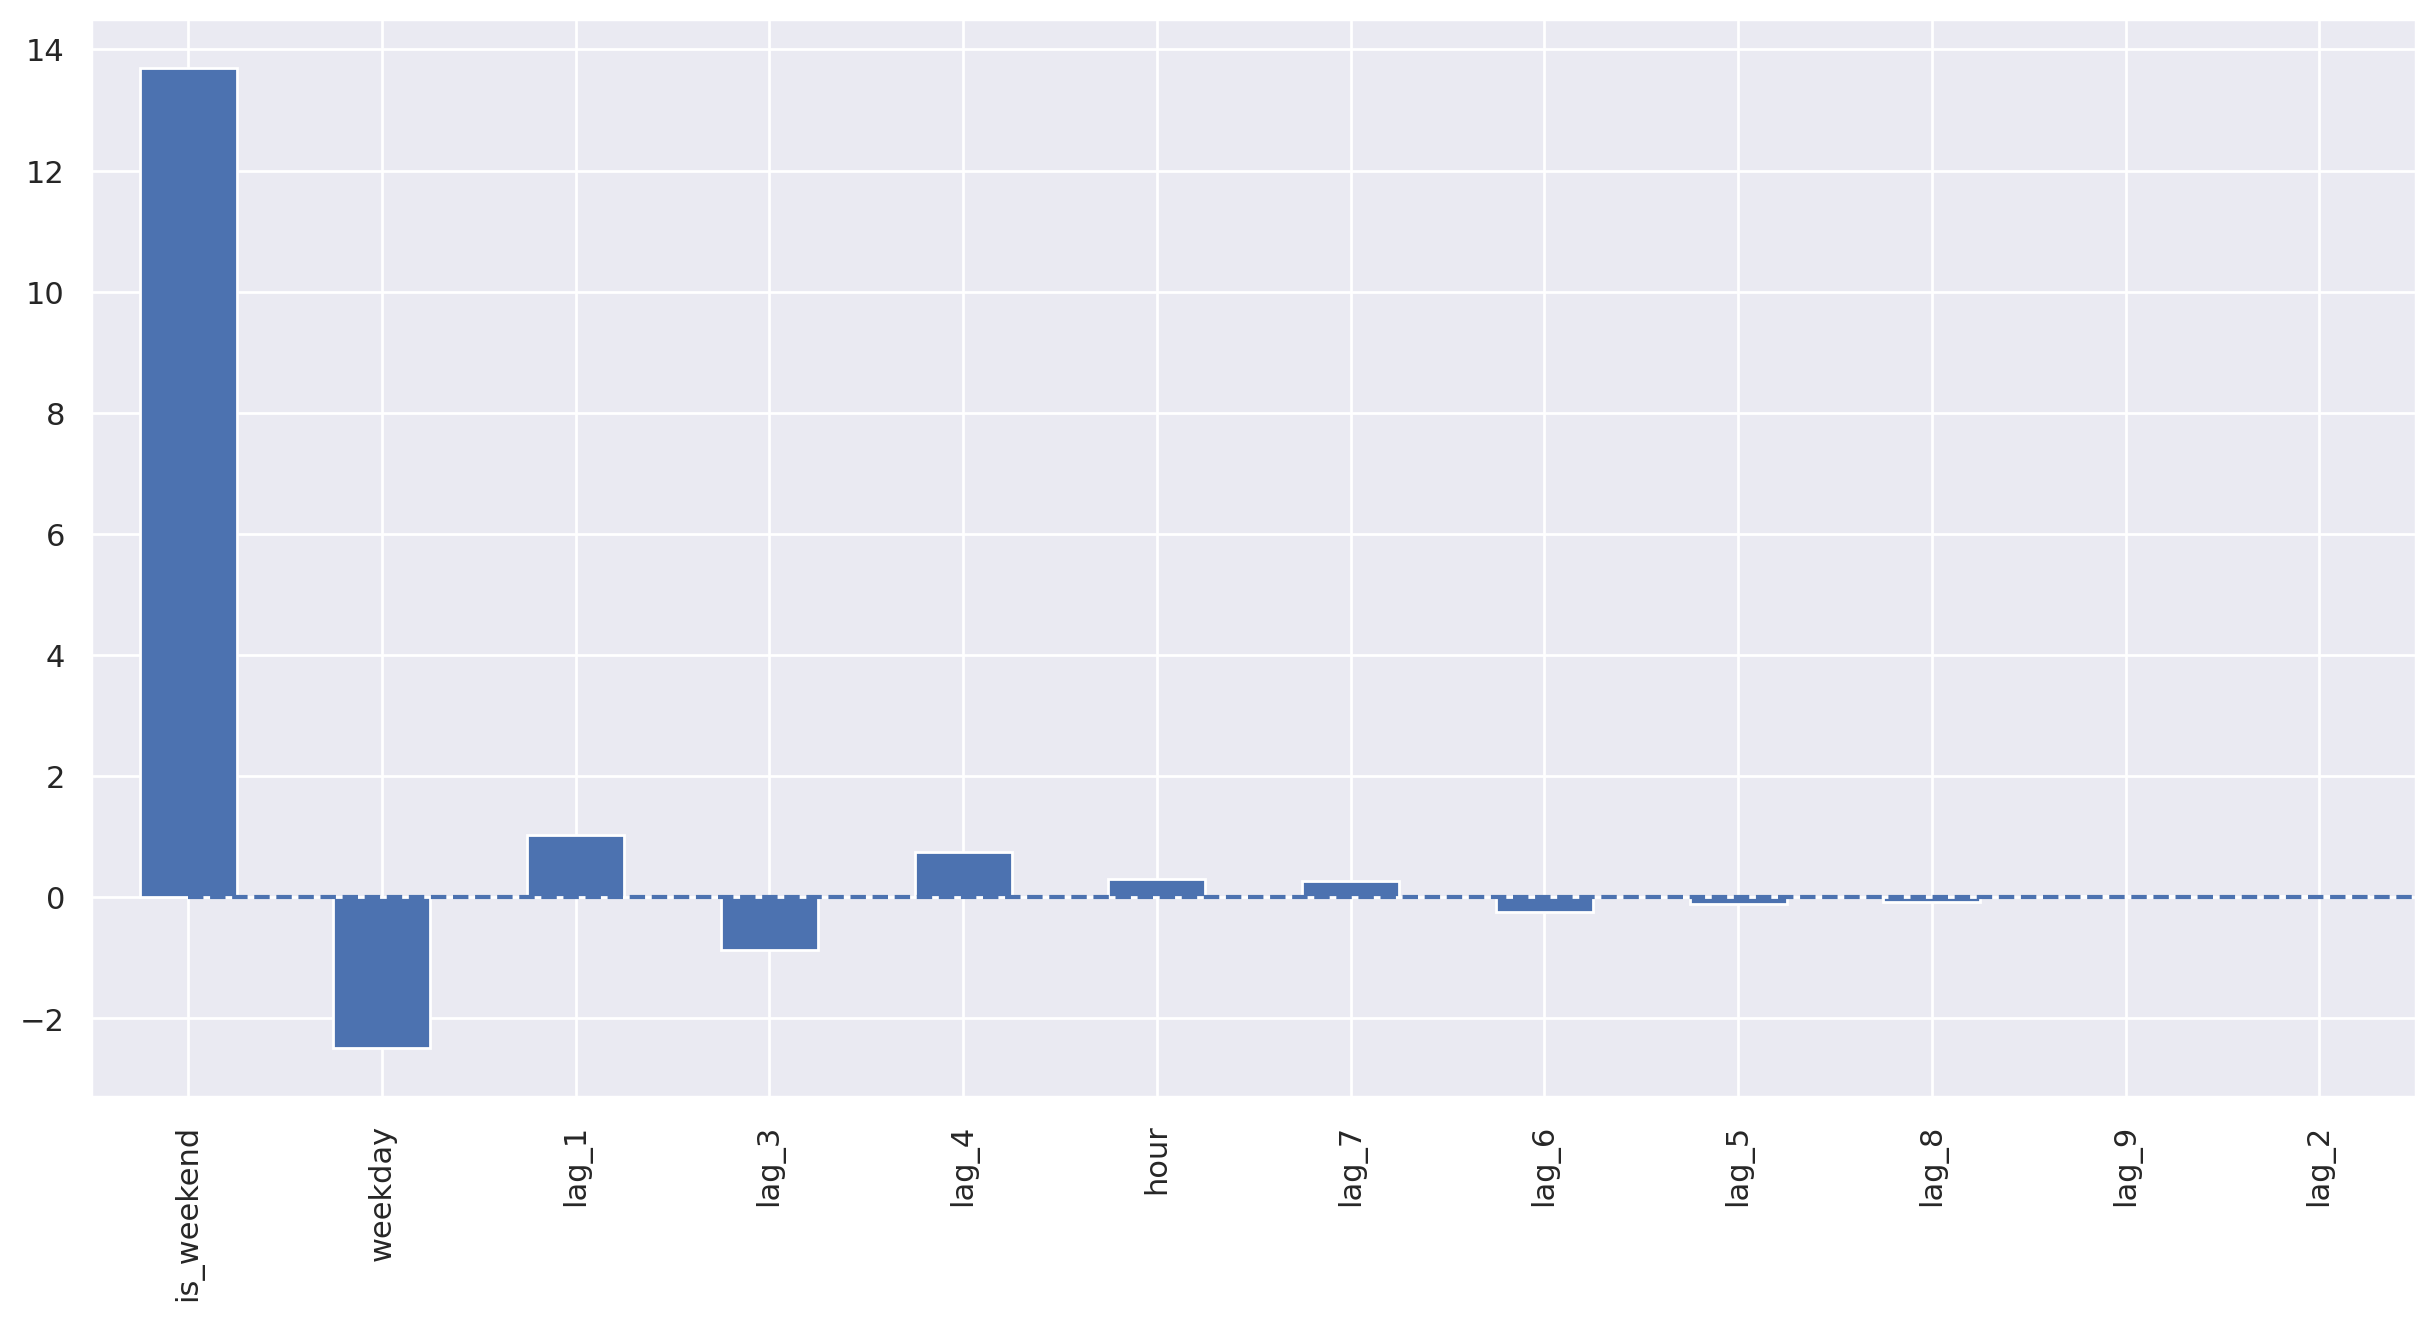

In [28]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_rm, y_train_rm)

plotModelResults(
    ridge,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)
plotCoefficients(ridge, X_train_rm)

**XGBRegressor and RandomForestRegressor**

In [29]:
from sklearn.ensemble import RandomForestRegressor

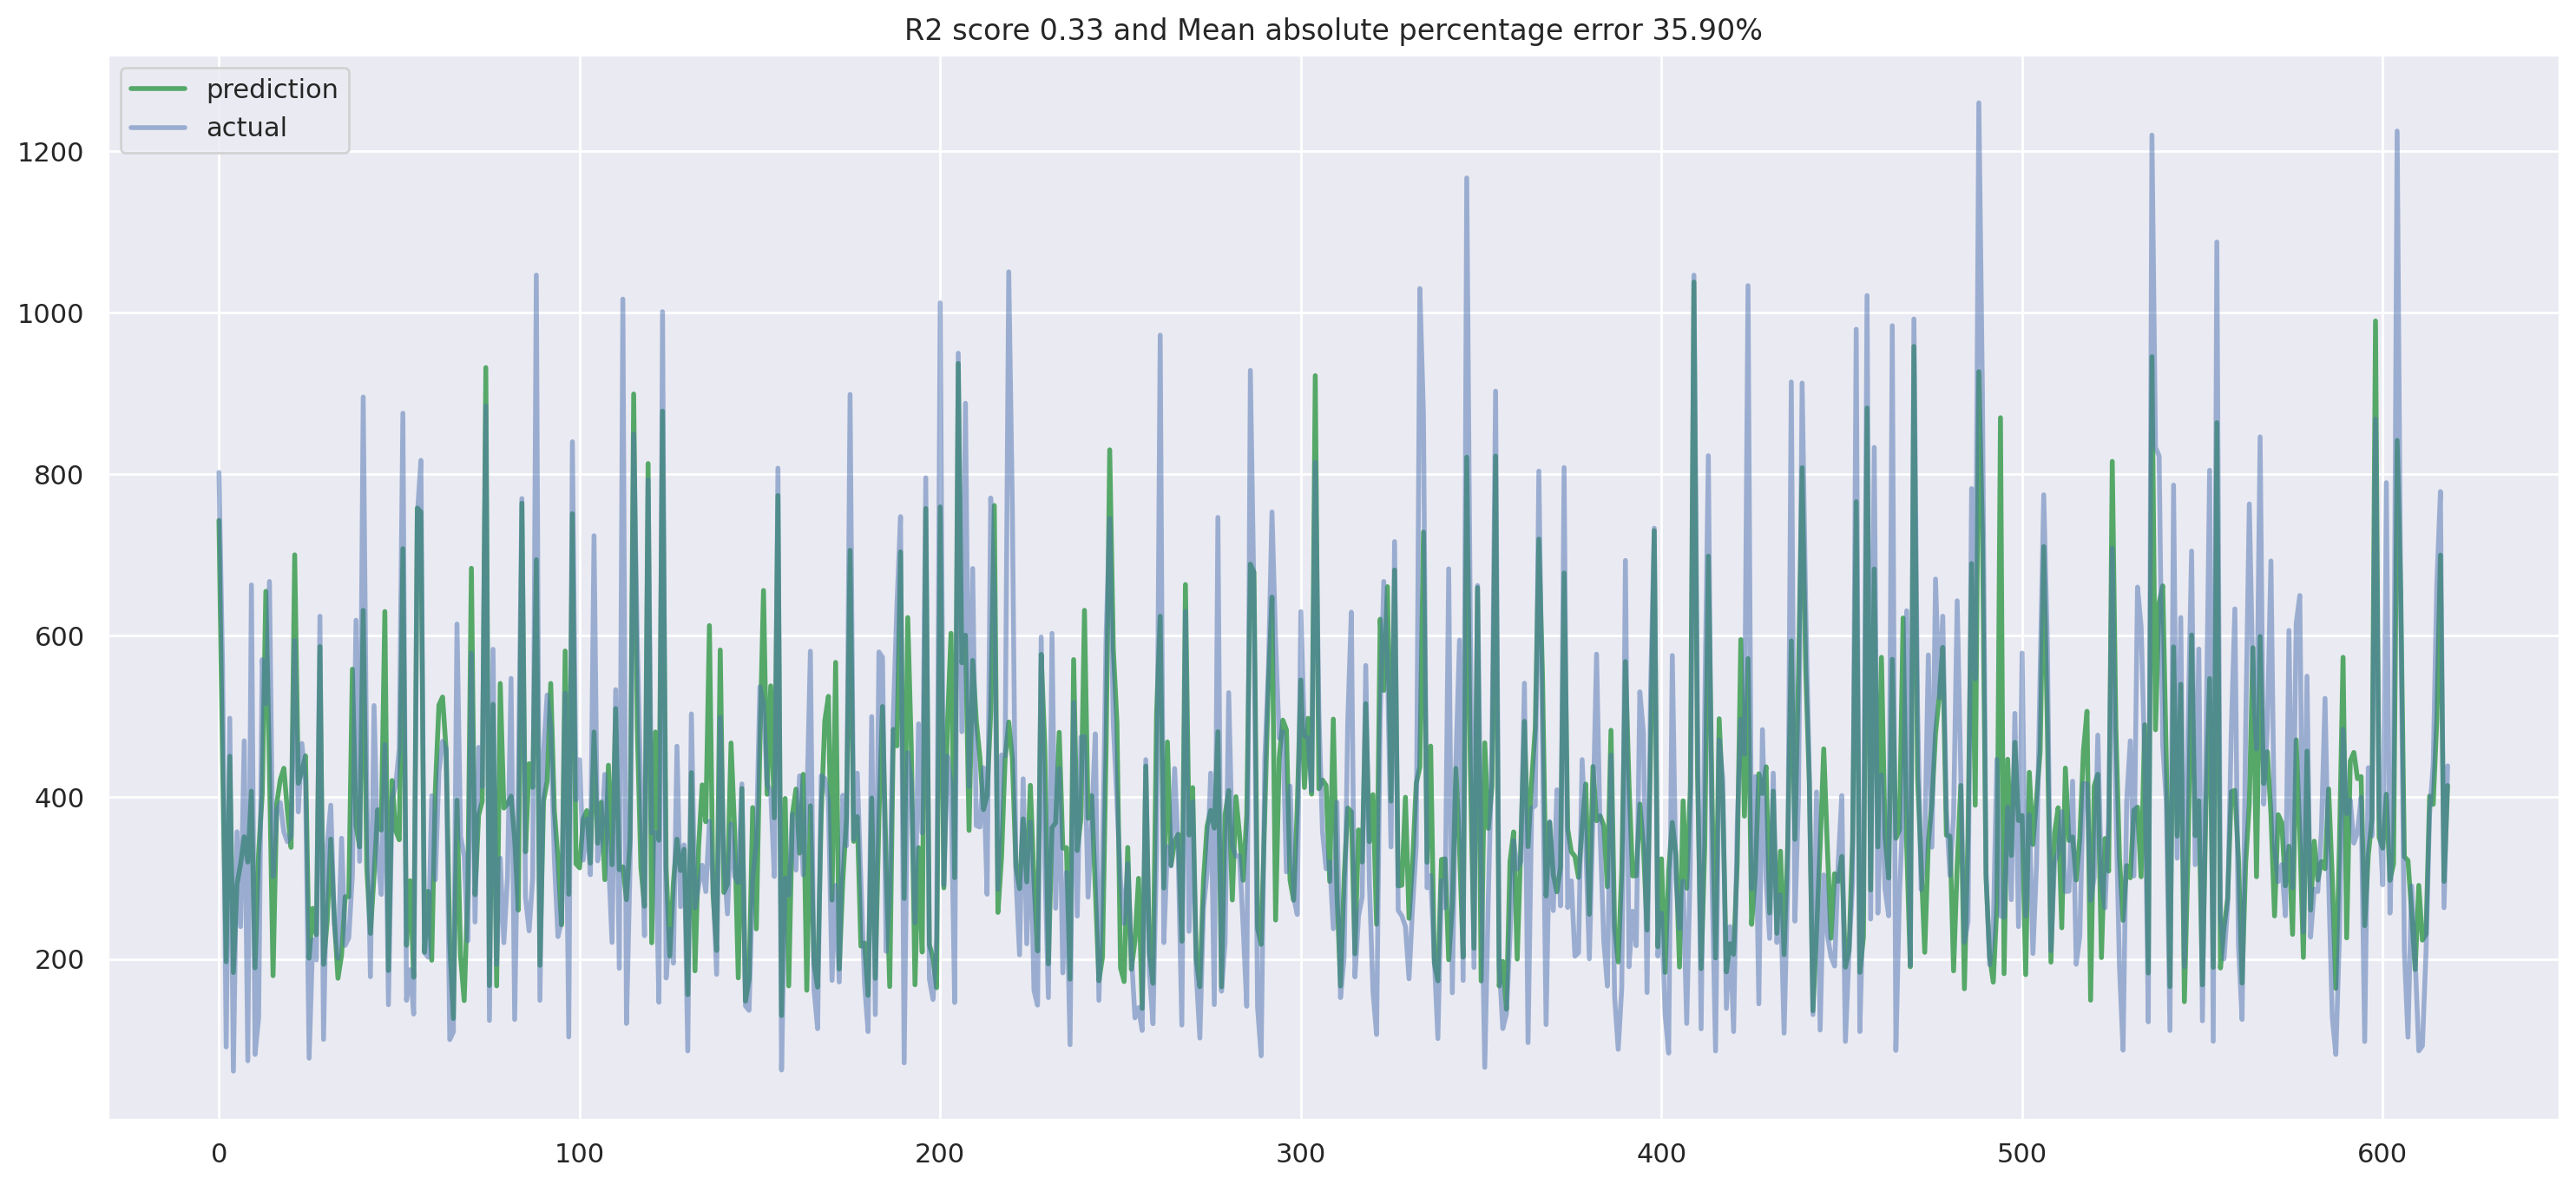

In [30]:
rf = RandomForestRegressor(n_jobs=-1, random_state=17)
rf.fit(X_train_rm, y_train_rm)
plotModelResults(
    rf,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)

In [31]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train_rm, y_train_rm);

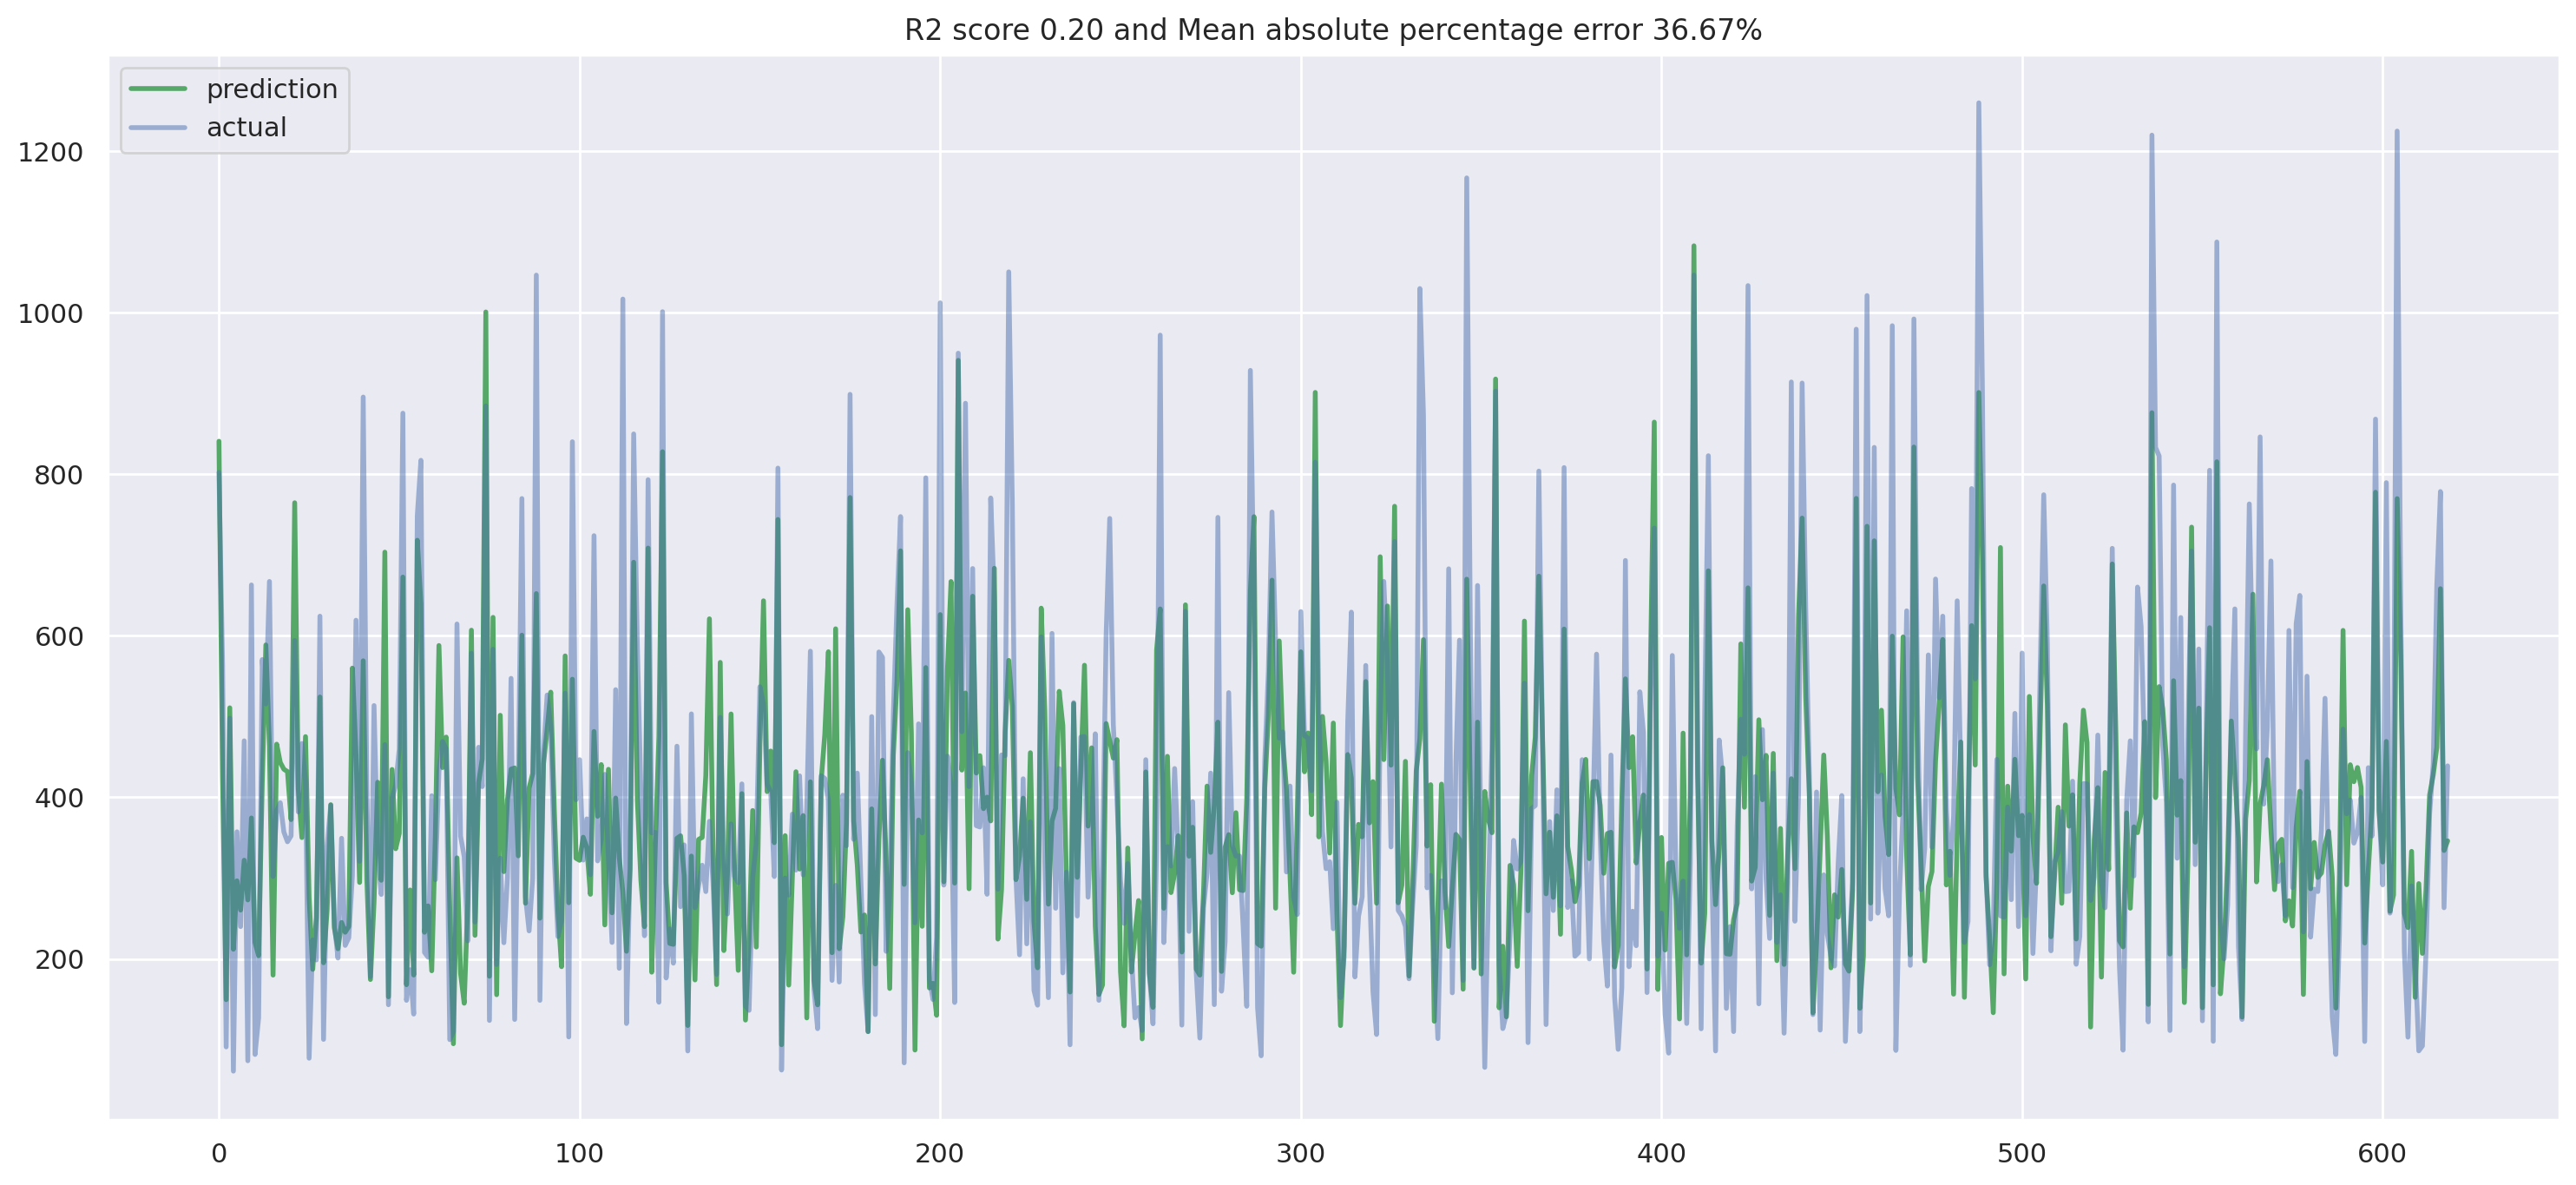

In [32]:
plotModelResults(
    xgb,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 264, number of used features: 12
[LightGBM] [Info] Start training from score 409.682828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

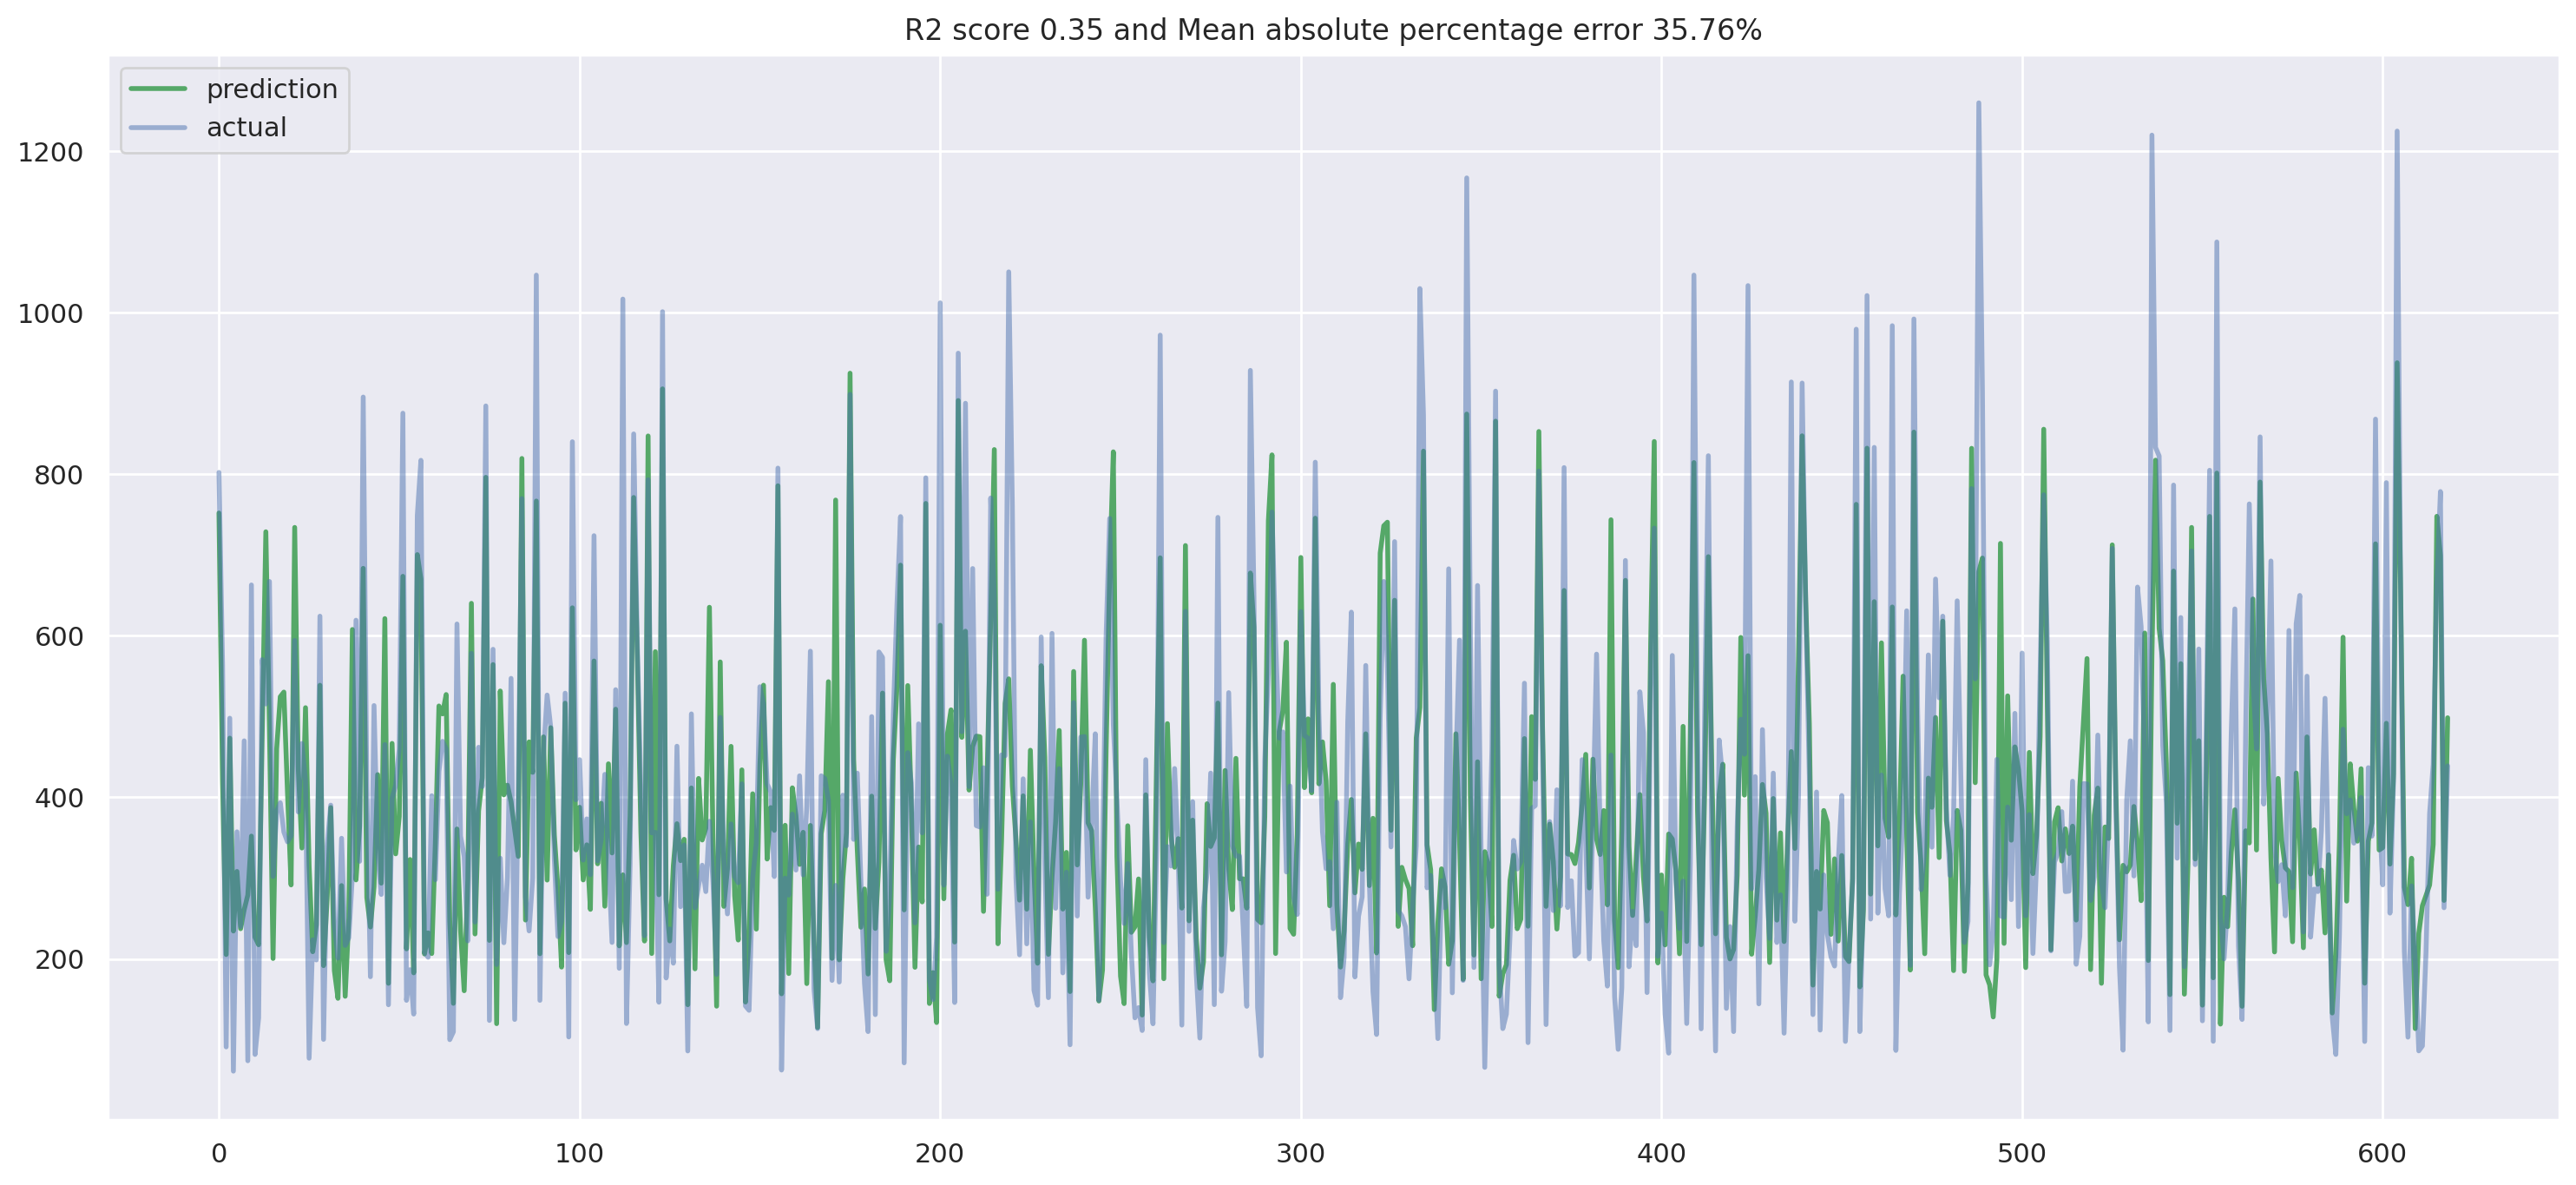

In [33]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(X_train_rm, y_train_rm);

plotModelResults(
    lgbm,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)

In [34]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()
br.fit(X_train_rm, y_train_rm);

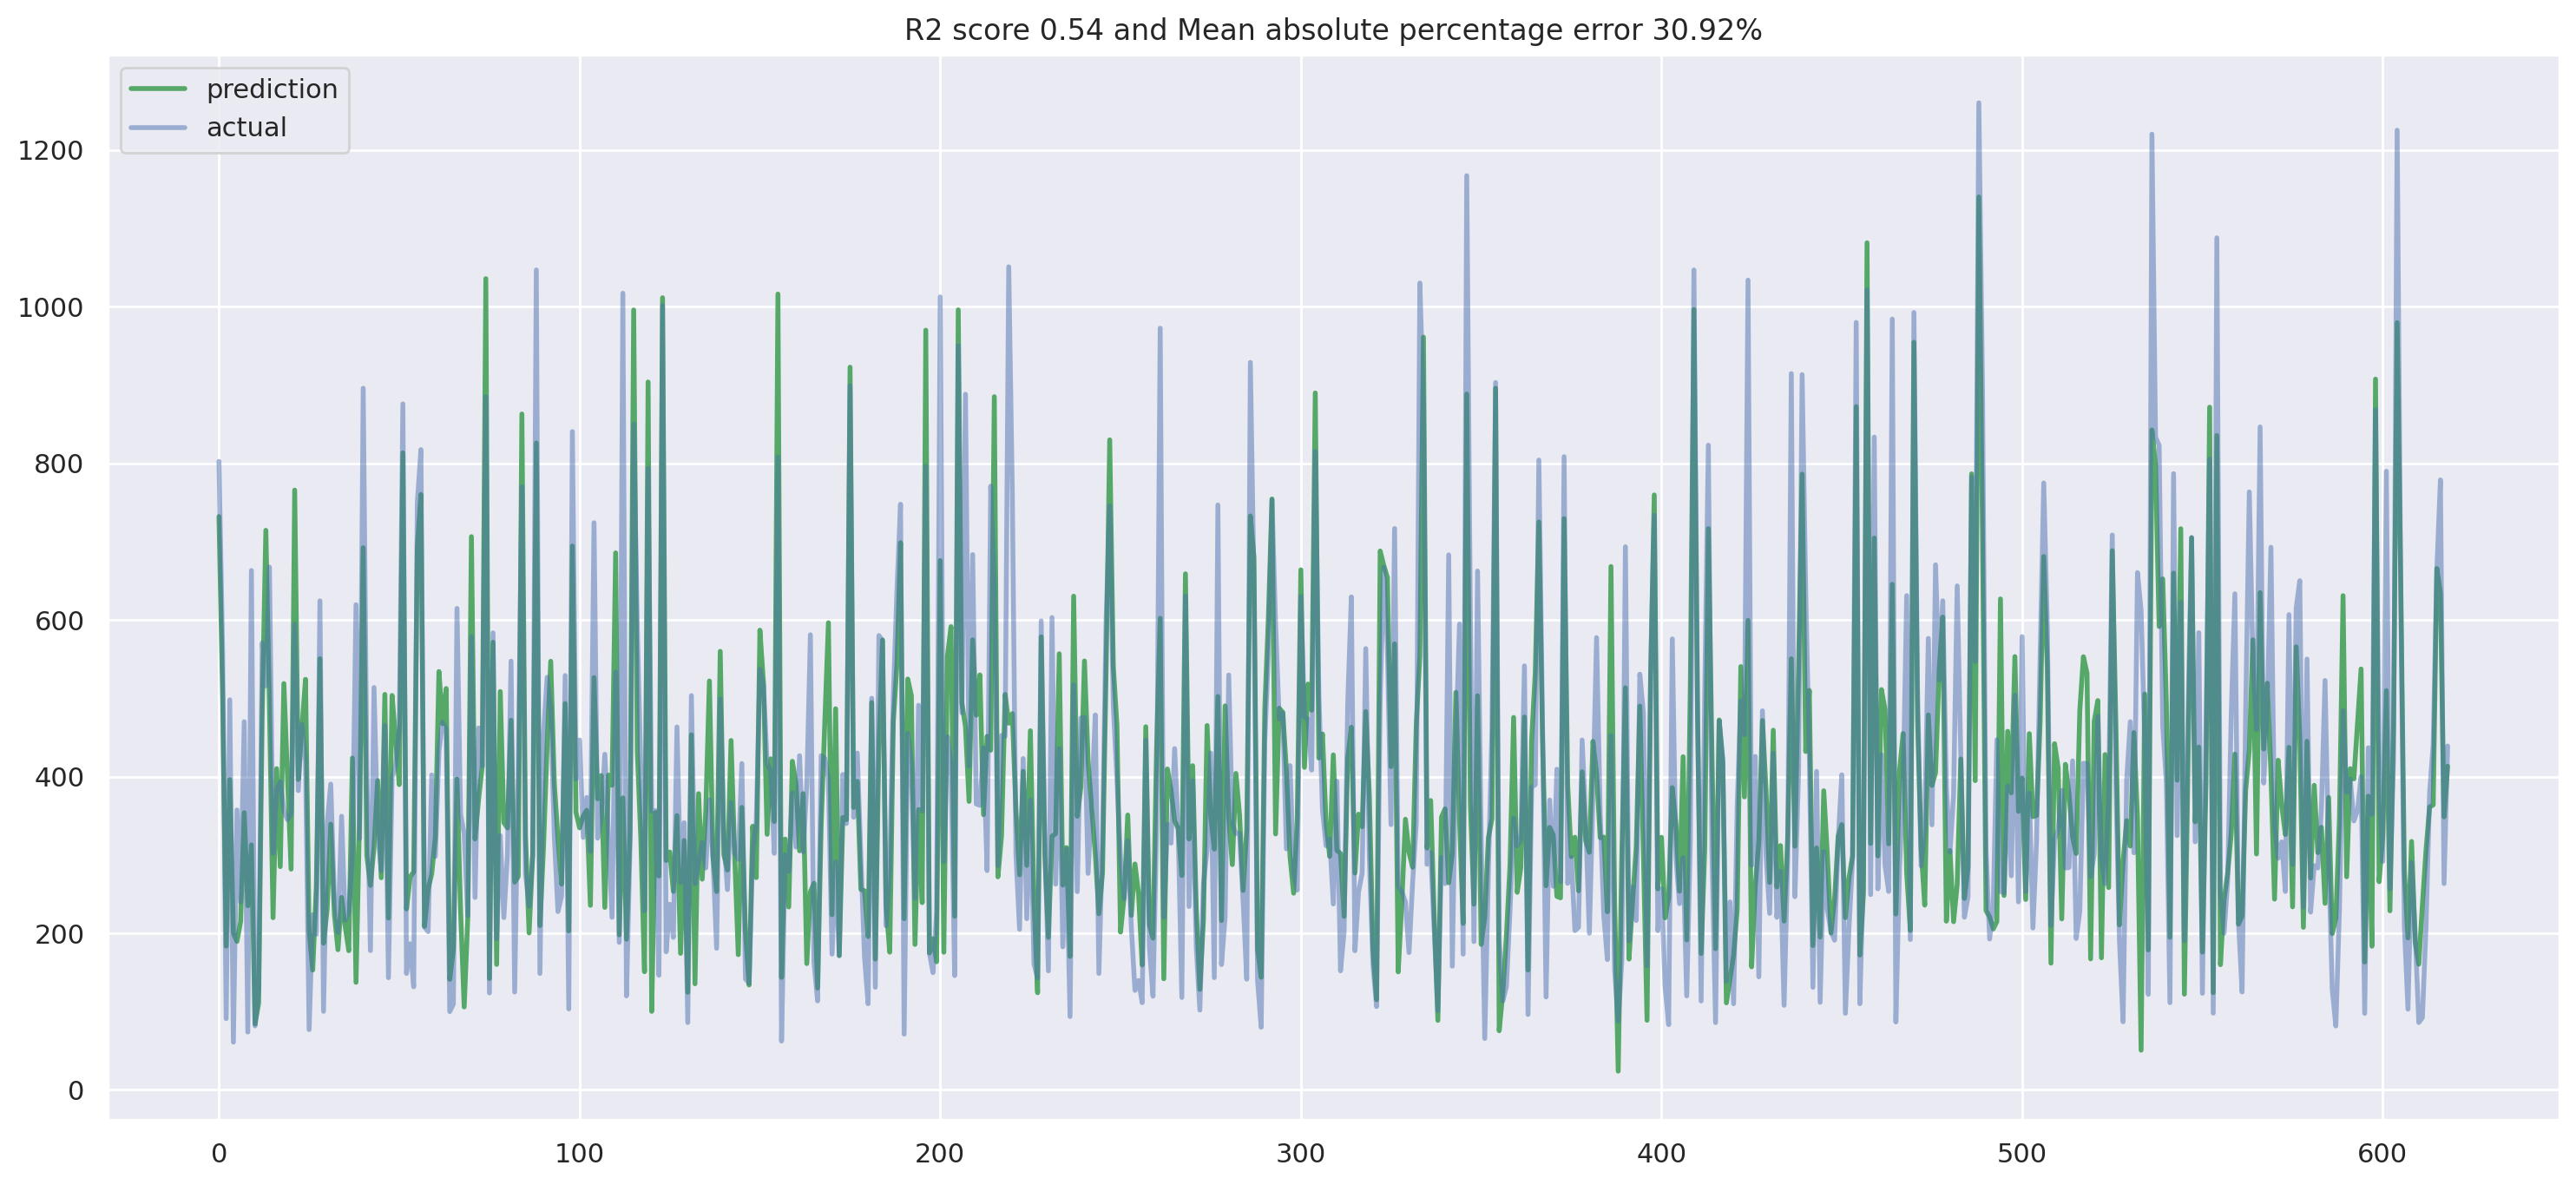

In [35]:
plotModelResults(
    br,
    X_train = X_train_rm,
    y_train = y_train_rm,
    X_test  = X_test_rm,
    y_test  = y_test_rm)

Automate the process w.r.t window, additional features and finally, another smoothing

Tune ensembles.

## Exponential Smoothing

In [36]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

In [37]:
data_exp = pd.DataFrame({'y':exponential_smoothing(data.y,alpha=0.3)},index=data.index)

In [38]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    #with plt.style.context("seaborn-white"):
    plt.figure(figsize=(15, 7))
    for alpha in alphas:
        plt.plot(
            exponential_smoothing(series, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(series.values, "c",alpha = 0.3, label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)
    plt.show()

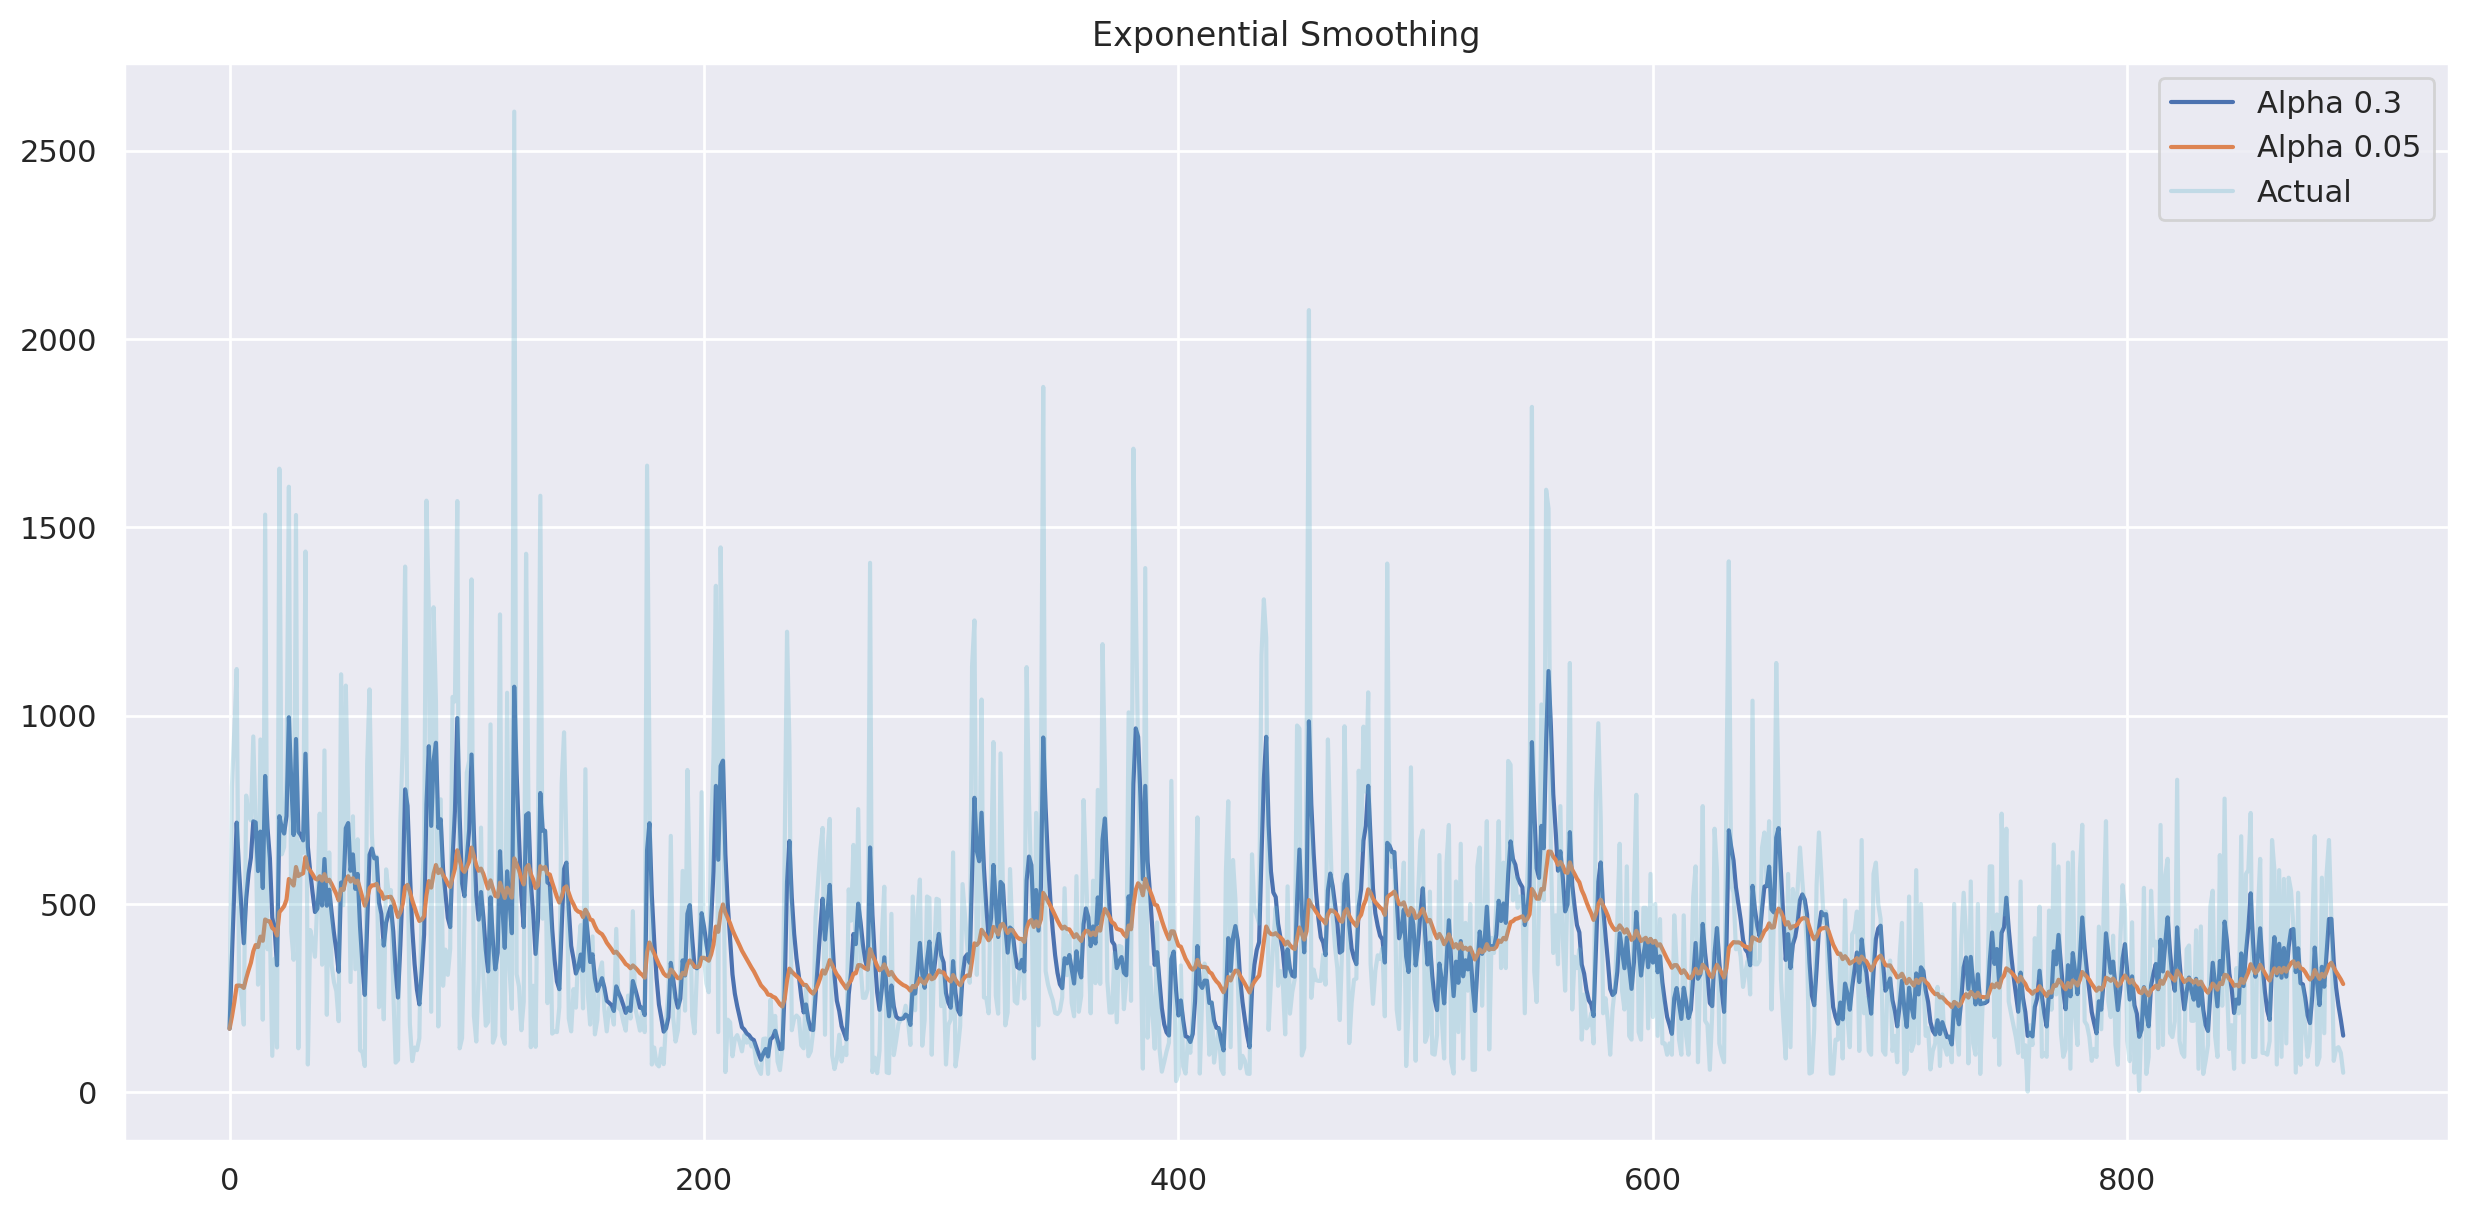

In [39]:
plotExponentialSmoothing(data.y, [0.3, 0.05])